Data Description
The dataset contains two files:

subject-info.csv contains the participant info at the time of the test. The variable ID identifies a participant, whereas the variable ID_test 
identifies an exercise test. This file contains 992 lines, one for each test. The different variables are described in the table below, with their 
corresponding amount or median [Inter Quartile Range] value.

variable

value

ID_test	992
ID	857
Age (years)	27.10 [21.10, 36.32]
Weight (kg)	73.00 [66.00, 80.23]
Height (cm)	175.00 [170.00, 180.00]
Humidity (%)	47.00 [42.00, 54.00]
Temperature (°C)	22.90 [20.80, 24.40]
Sex = 1 (Female) (%)	149 (15.0)


test_measure.csv, contains all the cardiorespiratory measurements taken during each effort test. The data is in long format, so the file contains one 
line for each breath measurement for all of the 992 effort tests, resulting in the 575087 lines present in the file. The time of each measurement is 
identified by the variable time indicating the seconds elapsed since the effort test start, the exercise test is identified by the ID_test variable,
and the variable ID indicates the participant. These effort tests contain a median [Inter Quartile Range] of 580 [484, 673] measures, for a median 
duration of 1093.00 [978.75, 1208.00] seconds. The variables in this file are:


time	Time since the measurement starts, in seconds
Speed	Speed of the treadmill, in km/h
HR	Heart rate, in beat per min
VO2	Oxygen consumption, in mL/min
VCO2	Carbon dioxide production, in mL/min
RR	Respiration rate, in respiration per minute
VE	Pulmonary ventilation, in L/min
ID	Participant identification
ID_test	Effort test identification
Note that VO2, VCO2, and VE measures are missing for 30 tests.

Usage Notes
ID_test, the variable identifying the GET, is named from the ID of the participant paired with the GET index. For example, ID_date = 245_3 is the third 
exercise test of participant ID = 245. An example of calculation in R [16] of simple heart rate recovery and cardiorespiratory index from these files
is provided in an associated GitHub repository [17].

## Importing Libraries

In [448]:
!pip install pywaffle
!pip install ipywidgets
!pip install ydata-profiling
%matplotlib inline
!pip install psycopg2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [449]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json

from mpl_toolkits.mplot3d import Axes3D

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
from pywaffle import Waffle

In [450]:
subject_i = pd.read_csv("subject-info.csv")
test_m = pd.read_csv("test_measure.csv")

In [451]:
subject_i.head()

Age  Weight  Height  Humidity  Temperature  Sex   ID ID_test
0  10.8    48.8   163.0      39.0         20.7    1  543   543_1
1  11.8    41.0   150.0      41.0         22.3    1   11    11_1
2  12.2    46.0   160.0      37.0         21.5    0  829   829_1
3  13.2    71.0   190.0      49.0         23.8    1  284   284_1
4  13.7    53.8   169.7      40.0         25.3    0  341   341_1

In [456]:
test_m.head()

time  Speed    HR    VO2   VCO2    RR    VE ID_test  ID
0     0    5.0  63.0  478.0  360.0  27.0  13.3     2_1   2
1     2    5.0  75.0  401.0  295.0  23.0  10.3     2_1   2
2     4    5.0  82.0  449.0  319.0  29.0  12.2     2_1   2
3     7    5.0  87.0  461.0  340.0  28.0  12.8     2_1   2
4     9    5.0  92.0  574.0  417.0  28.0  14.6     2_1   2

### 1. What is the average age of Female athletes who participated in this graded exercise tests?


In [459]:
female=subject_i[subject_i["Sex"]==1]
avg_age= np.mean(female['Age'])
print(f"Average age of Female Athletes who participated in the Graded Excercise tests is {avg_age}.")

Average age of Female Athletes who participated in the Graded Excercise tests is 26.044966442953022.


In [461]:
subject_i.columns


Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'ID',
       'ID_test'],
      dtype='object')

### 2. Visualize age distribution of all athletes and display the median value in the chart.

0      10.8
1      11.8
2      12.2
3      13.2
4      13.7
       ... 
987    59.1
988    59.7
989    61.3
990    61.6
991    63.0
Name: Age, Length: 992, dtype: float64 28.979133064516127


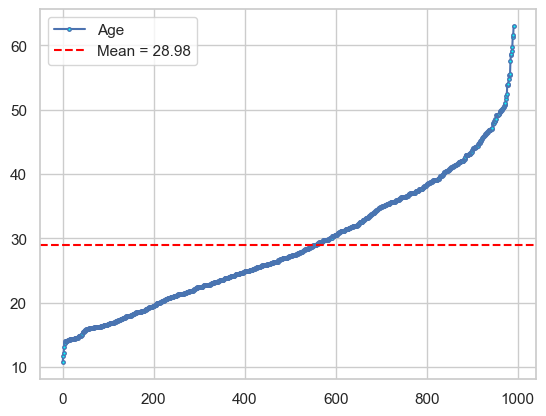

In [464]:
    
plt.plot(subject_i['Age'], label='Age',marker='o', ms=2.5, mfc='cyan')
mean_age=subject_i['Age'].mean()
print(subject_i['Age'],mean_age)

plt.axhline(mean_age, color='red', linestyle='--', label=f'Mean = {mean_age:.2f}')
plt.legend()
plt.show()

### 3.	Find the maximum time taken for all tests and then visualize the distribution of number of tests based on the test duration in minutes.Use a line chart and display the count of tests in the chart as well.


               maxtime   Count
suff_testid                   
1            28.533333  489844
2            20.983333    3676
3            22.550000    2119
4            21.400000    3070
5            20.283333    6060
...                ...     ...
128          19.266667     553
149          17.200000     601
166          19.083333     801
212          19.850000     693
371          22.733333     851

[68 rows x 2 columns]


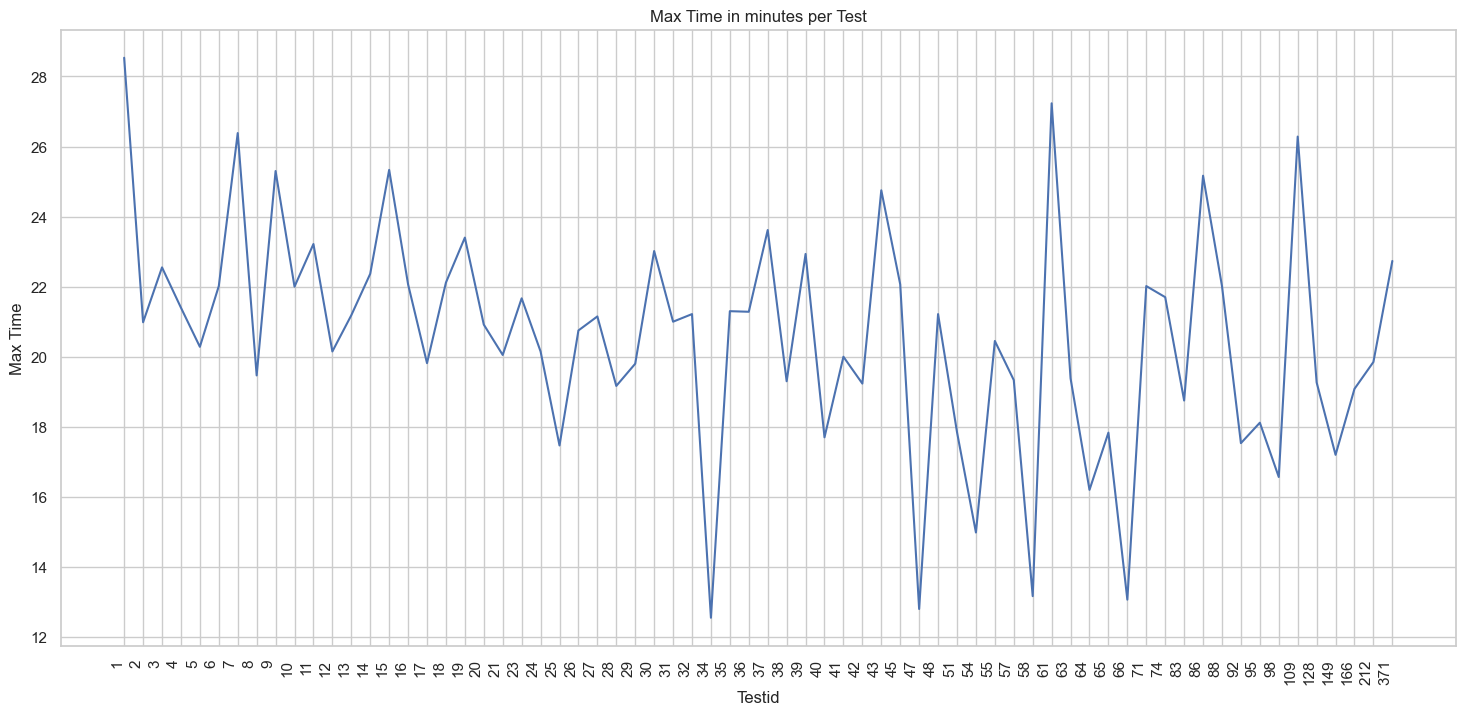

In [467]:
plt.figure(figsize=(18,8))
Time=pd.DataFrame(test_m['ID_test'], columns=['ID_test'])
Time['time']=test_m['time']/60

Time['suff_testid']=Time['ID_test'].str.split('_').str[1]

new_t= pd.DataFrame(Time.groupby(['suff_testid'])['time'].max())
new_t = new_t.rename(columns={'time': 'maxtime'})
m2= new_t.sort_values(by='suff_testid', key=lambda x: x.astype(int))
new_t1= pd.DataFrame(Time.groupby(['suff_testid'])['suff_testid'].count())
new_t1 = new_t1.rename(columns={'suff_testid': 'Count'})
merged_df = pd.merge(new_t, new_t1, on='suff_testid', how='inner')
merged_df=merged_df.sort_values(by='suff_testid', key=lambda x: x.astype(int))

print(merged_df)
y=m2['maxtime']

plt.tight_layout()
plt.xticks(rotation=90, ha='right')
plt.plot(y)
plt.title('Max Time in minutes per Test')
plt.xlabel('Testid')
plt.ylabel('Max Time')
plt.show()

In [474]:
#subject_i.columns


### 4. Display the consolidated list of overweight or obese people based on their BMI.

In [477]:
#BMI = Weight (kg) / [Height (cm)/100] /^2  
#BMI between 25 and 29.9 is considered overweight. 

BMI=pd.DataFrame(subject_i['ID'],columns=['ID'])
BMI['Weight']=subject_i['Weight']
BMI['Height']=subject_i['Height']
BMI['BMI']=subject_i['Weight']/((subject_i['Height']/100)**2)
#BMI['Age']=subject_i['Age']
Overweight= BMI[(BMI['BMI'] > 25) & (BMI['BMI'] < 29.9)]
print('List of Overweight or obese people as per their BMI:')
print(Overweight)

List of Overweight or obese people as per their BMI:
      ID  Weight  Height        BMI
34   134    76.0   173.0  25.393431
40   588    83.0   182.0  25.057360
41    40    77.0   165.0  28.282828
48   590    88.7   178.0  27.995203
54   313    68.0   158.0  27.239224
..   ...     ...     ...        ...
982  597    78.0   175.6  25.295635
985  755    64.0   157.0  25.964542
989  390   102.0   185.0  29.802776
990  596    74.0   169.0  25.909457
991  296    83.5   171.5  28.389532

[264 rows x 4 columns]


### 5.	Create a heatmap to visualize the correlations among any three cardiorespiratory measurements, Age, and BMI.

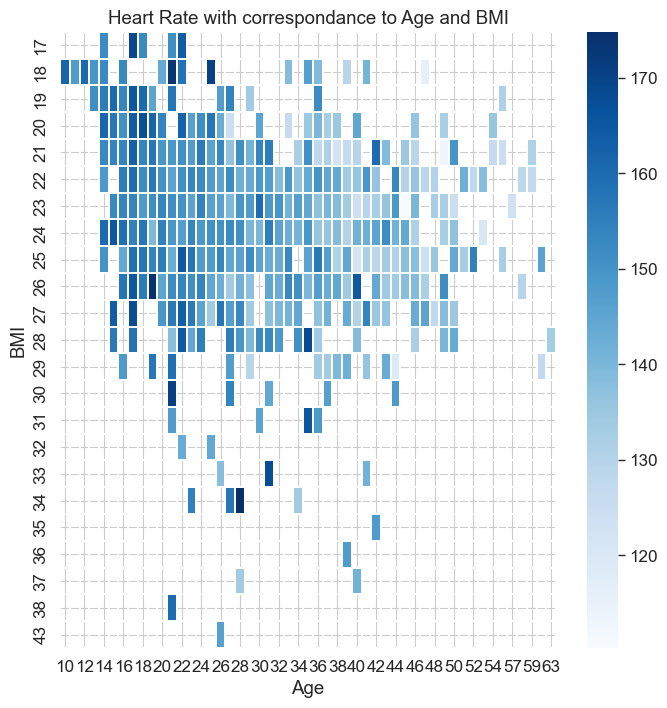

In [480]:

plt.figure(figsize=(8,8))
sns.set_context('paper', font_scale=1.4)

HR_H=pd.DataFrame(subject_i['ID_test'],columns=['ID_test'])
HR_H['Age']=subject_i['Age']
HR_H['BMI']=BMI['BMI']
#print(HR_H)

#grouped = merged_HR.groupby(['ID_test'])['HR'].mean().unstack()


heat=pd.DataFrame(test_m['ID_test'], columns=['ID_test'])
heat['HR']=test_m['HR']
heat.fillna(test_m['HR'].mean(), inplace=True)
heat.groupby(['ID_test'])['HR'].mean()
#print(heat)

merged_HR = pd.merge(HR_H, heat, on='ID_test', how='inner')
merged_HR['Age'] = merged_HR['Age'].round(1).astype(int)
merged_HR['BMI'] = merged_HR['BMI'].round(1).astype(int)

#print(merged_HR)
merged_HR = merged_HR.pivot_table(index='BMI', columns='Age', values='HR')
plt.title("Heart Rate with correspondance to Age and BMI")
sns.heatmap(merged_HR, cmap='Blues', linewidth=0.1)
plt.show()

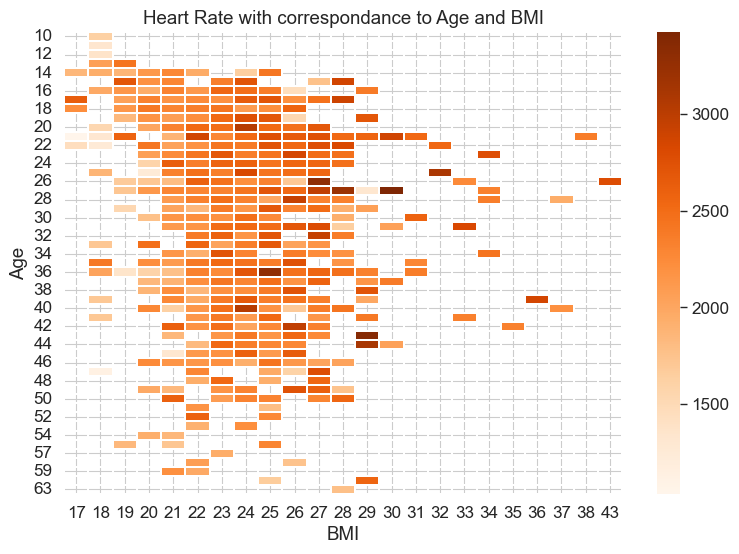

In [482]:
plt.figure(figsize=(9,6))
sns.set_context('paper', font_scale=1.4)

Vo2_H=pd.DataFrame(subject_i['ID_test'],columns=['ID_test'])
Vo2_H['Age']=subject_i['Age']
Vo2_H['BMI']=BMI['BMI']
#print(HR_H)

#grouped = merged_HR.groupby(['ID_test'])['HR'].mean().unstack()


heat=pd.DataFrame(test_m['ID_test'], columns=['ID_test'])
heat['VO2']=test_m['VO2']
#heat.fillna(test_m['HR'].mean(), inplace=True)
#heat.groupby(['ID_test'])['HR'].mean()
#print(heat)

merged_vo2 = pd.merge(Vo2_H, heat, on='ID_test', how='inner')
merged_vo2['Age'] = merged_vo2['Age'].round(1).astype(int)
merged_vo2['BMI'] = merged_vo2['BMI'].round(1).astype(int)

#print(merged_HR)
merged_vo2 = merged_vo2.pivot_table(index='Age', columns='BMI', values='VO2')
sns.heatmap(merged_vo2, cmap='Oranges', linewidth=0.1)
plt.title("Heart Rate with correspondance to Age and BMI")
plt.show()

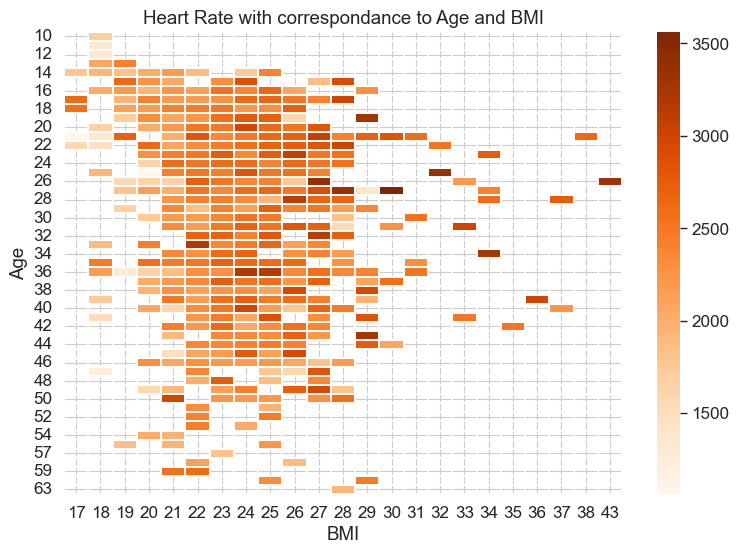

In [484]:
plt.figure(figsize=(9,6))
sns.set_context('paper', font_scale=1.4)

Vco2_H=pd.DataFrame(subject_i['ID_test'],columns=['ID_test'])
Vco2_H['Age']=subject_i['Age']
Vco2_H['BMI']=BMI['BMI']

heat=pd.DataFrame(test_m['ID_test'], columns=['ID_test'])
heat['VCO2']=test_m['VCO2']


merged_vco2 = pd.merge(Vco2_H, heat, on='ID_test', how='inner')
merged_vco2['Age'] = merged_vco2['Age'].round(1).astype(int)
merged_vco2['BMI'] = merged_vco2['BMI'].round(1).astype(int)

#print(merged_HR)
merged_vco2 = merged_vco2.pivot_table(index='Age', columns='BMI', values='VCO2')
sns.heatmap(merged_vco2, cmap='Oranges', linewidth=0.1)
plt.title("Heart Rate with correspondance to Age and BMI")
plt.show(block=True)

### 6 Generate subplots for second-degree trigonometric functions,using x=np.arange(0,4*np.pi,0.1) in object oriented approach. Label every π interval on X axis.

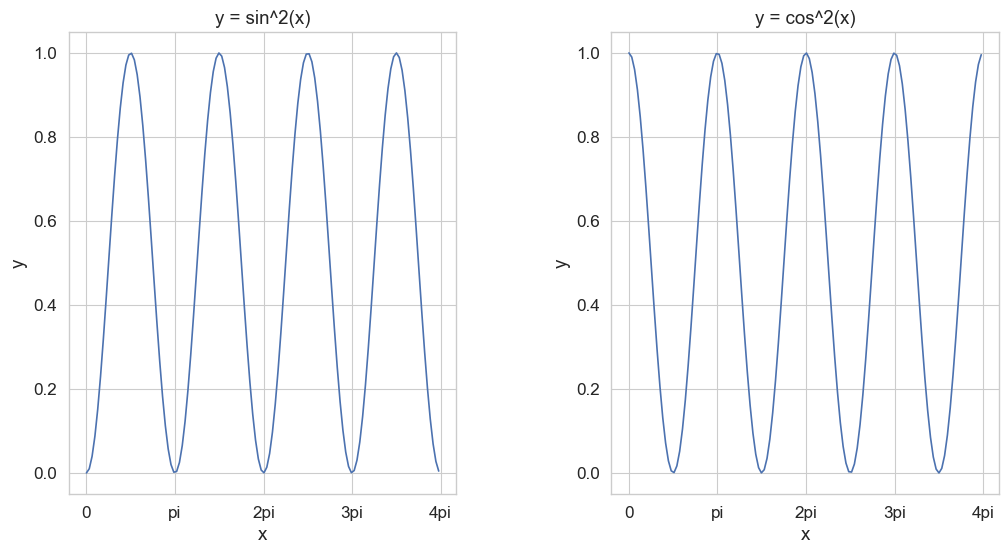

In [487]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
x=np.arange(0,4*np.pi,0.1)
y = np.sin(x)**2
plt.plot(x, y)
xticks = [0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi]
xtick_labels = ['0', 'pi', '2pi', '3pi', '4pi']
plt.xticks(xticks, xtick_labels)
plt.title("y = sin^2(x)")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1,2,2)
x=np.arange(0,4*np.pi,0.1)
y = np.cos(x)**2
plt.plot(x, y)
xticks = [0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi]
xtick_labels = ['0', 'pi', '2pi', '3pi', '4pi']
plt.xticks(xticks, xtick_labels)
plt.title("y = cos^2(x)")
plt.xlabel("x")
plt.ylabel("y")


plt.subplots_adjust(wspace=0.4) 

plt.show()

### 7. Get a number from the user and print its multiplication table from 1 to 10.

In [490]:
n = int(input("Enter an integer number: "))

i=1
print(f"Multiplication table for {n}")
for i in range(1,11):
  m=n*i
  print(f"{n}*{i} ={m}")

  i +=1
  if i == 11:
      break


Enter an integer number:  6


Multiplication table for 6
6*1 =6
6*2 =12
6*3 =18
6*4 =24
6*5 =30
6*6 =36
6*7 =42
6*8 =48
6*9 =54
6*10 =60


### 8. Write a function to display a correlation matrix between speed of the treadmill and any cardiorespiratory measurement of the athelete. (Exclude warmup period).

In [492]:
#assuming the Warmup peroid as a HR under 95

CR1=pd.DataFrame(test_m['ID_test'], columns=['ID_test'])
CR1['speed']=test_m['Speed']
CR1['HR']=test_m['HR']
CR1=CR1[CR1['HR']>=95]
def display_hr_speed_correlation(df, method='kendall', figsize=(6, 5), annot=True, cmap='coolwarm'):

    df = df.reset_index(drop=True)  
    subset = df[['HR', 'speed']].dropna() 
    corr = subset.corr(method=method)
    # plt.figure(figsize=figsize)
    # sns.heatmap(corr, annot=annot, cmap=cmap, fmt=".2f", square=True, linewidths=0.5)
    # plt.title(f'{method.capitalize()} Correlation between HR and Speed', fontsize=14)
    # plt.xticks()
    # plt.yticks()
    # plt.show()
    return corr

c1= display_hr_speed_correlation(CR1)
print("Below is the correlation matrix for Speed Vs Heart rate:")
print(c1)

Below is the correlation matrix for Speed Vs Heart rate:
             HR     speed
HR     1.000000  0.484358
speed  0.484358  1.000000


### 9	What percentage of athletes exceeded 90% of max HR after warm up period? 

In [495]:
#considering 10 minutes as warm up peroid

DF= pd.DataFrame(test_m['HR'], columns=['HR'])
DF['ID']=test_m['ID']
DF['time']=test_m['time']
#print(DF)
total_participants=DF['ID'].nunique()
maxhr90=DF['HR'].max()*.90
#print(maxhr90,total_participants)

above_90=DF[(DF["HR"]>maxhr90) & (DF["time"]>600)]
Participants_abv90=above_90['ID'].nunique()
#print(above_90)
#print(Participants_abv90)

Total_percentage=Participants_abv90/total_participants*100

print(f'{Total_percentage}% of total partocoapnts have exceeded the 90 % of max HR after warm up peroid')

5.950991831971995% of total partocoapnts have exceeded the 90 % of max HR after warm up peroid


### 10 Which athlete spent the longest time period in this exercise program to complete all of their cardiorespiratory measurements (including the time interval between different test cases)?

In [498]:
Time1=pd.DataFrame(test_m['ID_test'], columns=['ID_test'])
Time1['time']=test_m['time']
Time1['ID']=test_m['ID']

time_grp=Time1.groupby(['ID_test'])
t1=time_grp.max()
new_tm=pd.DataFrame(t1.groupby(['ID'])['time'].sum())

max2 =new_tm['time'].idxmax()
max1= new_tm.loc[max2]

print(f'Participant {max2} spent the longest time in the exercise program. Time spent by them is {max1['time']} seconds')

Participant 506 spent the longest time in the exercise program. Time spent by them is 6017 seconds


### 11.	Plot a 3-D graph using any set of random values chosen by you

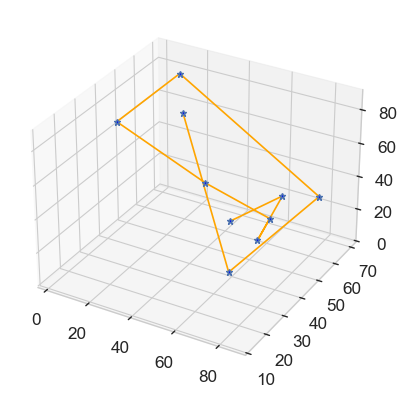

In [501]:
from mpl_toolkits.mplot3d import Axes3D

x=np.random.randint(0,100,10)
y=np.random.randint(10,100,10)
z=[1,20,50,23,45,68,78,41,39,90]
fig=plt.figure()  #This creates a new figure canvas using matplotlib.pyplot.figure().
ax = fig.add_subplot(111, projection='3d') #represents your 3D axes object.
ax.plot3D(x, y, z, 'orange', marker='*', mec='b', mfc='blue')
plt.show()

### 12.connect to database using PostgreSQL and get the details of participants in test 1 and age > 50

In [504]:
import psycopg2

conn = psycopg2.connect(
    dbname="subject_info",
    user="postgres",
    password="pgdb",
    host="localhost",
    port="5432"
)

cur = conn.cursor()

cur.execute("""
select * from subject_info 
where 
Age > 50
and
rtrim(ID_test) like '%\\_1' escape '\\';
""")

column_names = [desc[0] for desc in cur.description]
results = cur.fetchall()

print("  ".join(column_names))

for row in results:
  print("\t".join(str(item) for item in row))
  
cur.close()
conn.close()

OperationalError: connection to server at "localhost" (::1), port 5432 failed: FATAL:  password authentication failed for user "postgres"


In [506]:
#subject_i.columns


Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'ID',
       'ID_test'],
      dtype='object')

### 13	Make athelete ID as index to the subject_info table and arrange index in sorted order.


In [508]:
subject_i1 = subject_i.copy()

#subject_i1.set_index('ID', inplace=True)
subject_i1=subject_i1.sort_index()
print(subject_i1)

      Age  Weight  Height  Humidity  Temperature  Sex   ID ID_test
0    10.8    48.8   163.0      39.0         20.7    1  543   543_1
1    11.8    41.0   150.0      41.0         22.3    1   11    11_1
2    12.2    46.0   160.0      37.0         21.5    0  829   829_1
3    13.2    71.0   190.0      49.0         23.8    1  284   284_1
4    13.7    53.8   169.7      40.0         25.3    0  341   341_1
..    ...     ...     ...       ...          ...  ...  ...     ...
987  59.1    64.7   172.0      38.0         24.4    0  856   856_2
988  59.7    65.2   172.0      51.0         16.8    0  856   856_3
989  61.3   102.0   185.0      56.0         20.5    0  390   390_1
990  61.6    74.0   169.0      46.0         23.9    0  596   596_1
991  63.0    83.5   171.5      48.0         22.2    0  296   296_1

[992 rows x 8 columns]


In [510]:
#subject_i.columns


Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'ID',
       'ID_test'],
      dtype='object')

### 14. Calculate RER (Respiratory Exchange Ratio) , and categorize exercise phase to warmup, moderate, peak exercise according to RER.

In [512]:
# RER=the ratio of carbon dioxide (CO2) produced to oxygen (O2) consumed
test1=pd.DataFrame(test_m['ID'], columns=['ID'])
test1['VCO2']=test_m['VCO2']
test1['VO2']=test_m['VO2']
test1['ID_test']=test_m['ID_test']
test1['RER'] =test1['VCO2']/test1['VO2']
test1['RER']=test1['RER'].fillna(test1['RER'].mean())
test1.sort_values("RER", inplace=True)

#assuming the RER range from warmup, moderate and peak exercise as 0.5-0.85- 1
#warmup -0.5 to 0.85
#moderate - 0.85 - 1
#peak greater than 1

def categorize(RER):
 if RER >=1 :
    return 'Peak Exercise'

 elif RER >=0.85:
      return 'Moderate Exercise'

 else:
      return 'Warmup'

test1['category'] = test1['RER'].apply(categorize)

print(test1 )

         ID    VCO2     VO2 ID_test        RER       category
201685  305   344.0   678.0   305_1   0.507375         Warmup
212751  330   417.0   821.0   330_1   0.507917         Warmup
201688  305   337.0   660.0   305_1   0.510606         Warmup
351603  518   510.0   998.0   518_1   0.511022         Warmup
201687  305   343.0   671.0   305_1   0.511177         Warmup
...     ...     ...     ...     ...        ...            ...
471228  693  1328.0   500.0   693_1   2.656000  Peak Exercise
557428  831  3316.0  1238.0   831_1   2.678514  Peak Exercise
291563  439   294.0   107.0   439_1   2.747664  Peak Exercise
471227  693  1348.0    82.0   693_1  16.439024  Peak Exercise
471226  693  1350.0    82.0   693_1  16.463415  Peak Exercise

[575087 rows x 6 columns]


### 15	Calculate the moving average(rolling mean) of HR for participant with ID 2 in a window size of 10 and plot a graph to show both moving average and original HR.



        HR  moving_avg
0     63.0  138.894148
1     75.0  138.894148
2     82.0  138.894148
3     87.0  138.894148
4     92.0  138.894148
..     ...         ...
597  120.0  121.600000
598  120.0  121.200000
599  121.0  121.000000
600  121.0  120.900000
601  121.0  120.800000

[602 rows x 2 columns]


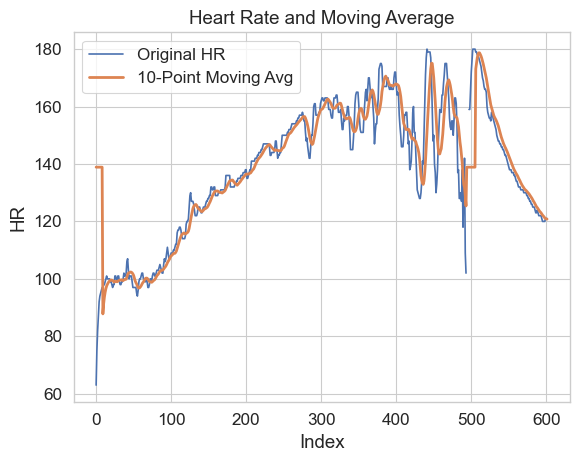

In [515]:

mov_avg=pd.DataFrame(test_m[test_m['ID']==2], columns=['HR'])
mov_avg['moving_avg'] = mov_avg['HR'].rolling(window=10).mean()

mov_avg['moving_avg'].fillna(mov_avg['moving_avg'].mean(), inplace=True)
print(mov_avg)

plt.plot(mov_avg['HR'], label='Original HR')
plt.plot(mov_avg['moving_avg'], label='10-Point Moving Avg', linewidth=2)
plt.title('Heart Rate and Moving Average')
plt.xlabel('Index')
plt.ylabel('HR')
plt.legend()
plt.show()


### 16 What was the average time each test lasted for all athletes ?

In [518]:
Time=pd.DataFrame(test_m['ID_test'], columns=['ID_test'])
Time['time']=test_m['time']


new_t= pd.DataFrame(Time.groupby(['ID_test'])['time'].max().reset_index())
new_t = new_t.rename(columns={'time': 'maxtime'})
new_t['testid']=new_t['ID_test'].str.split('_').str[1]

new_t2= pd.DataFrame(new_t.groupby(['testid'])['maxtime'].mean().reset_index())
new_t2= new_t2.sort_values(by='testid', key=lambda x: x.astype(int))

print("Below are the average times taken by all the participants for each test:")
print(new_t2)

Below are the average times taken by all the participants for each test:
   testid      maxtime
0       1  1082.424737
15      2  1062.666667
26      3  1143.750000
37      4  1079.400000
45      5  1042.888889
..    ...          ...
5     128  1156.000000
8     149  1032.000000
11    166  1145.000000
18    212  1191.000000
34    371  1364.000000

[68 rows x 2 columns]


In [520]:
#subject_i.columns


Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'ID',
       'ID_test'],
      dtype='object')

### 17.Display a histogram showing the distribution of athletes by their BMI values.

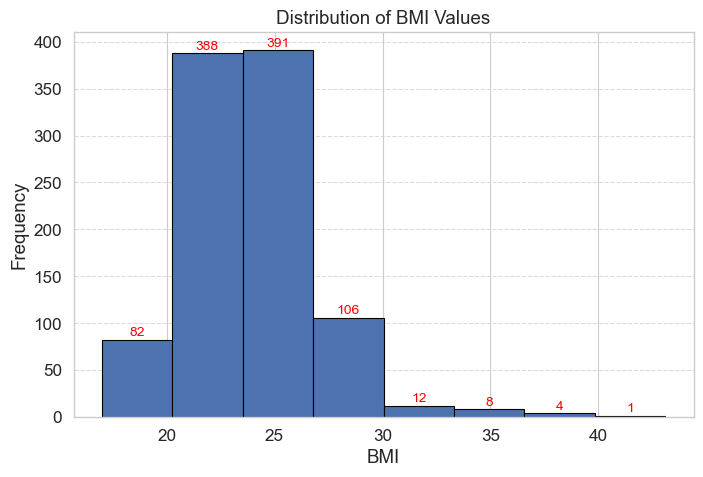

In [522]:
#Calculating the BMI values
subject_df = subject_i.copy()
subject_df['BMI'] = round(subject_df['Weight'] / ((subject_df['Height'] /100) **2),1)
#print(subject_i['BMI'])

#histogram plot for BMI distribution
plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(subject_df['BMI'], bins=8, edgecolor='black')
#print("Bin edges:", bins)
#print("Frequencies:", counts)
plt.title('Distribution of BMI Values')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label each bar with the count on top
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(
        patch.get_x() + patch.get_width() / 2,  # X-position (center of bar)
        height + 1,                             # Y-position (slightly above bar)
        int(count),                             # Text (count value)
        ha='center', va='bottom', fontsize=10, color='RED'  # Label alignment, fontsize and its color
            )

plt.show()



In [524]:
#subject_i.columns


Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'ID',
       'ID_test'],
      dtype='object')

### 18. " Who is the tallest participant in the dataset? What is  his/her Vo2 kg/ml?"

In [526]:
# Merge the two DataFrames on 'ID'
combined_df = pd.merge(subject_i, test_m, on='ID')

# Find the tallest person
tallest_person = combined_df[combined_df['Height'] == combined_df['Height'].max()]
print(f"ID of the Tallest Person in the Dataset is: {tallest_person['ID'].values[0]}")

# Calculate peak VO2 per kg
max_vo2 = tallest_person['VO2'].max()
vo2_kg_ml = max_vo2 / tallest_person['Weight'].iloc[0]
print("Peak VO₂ (mL/kg/min):", round(vo2_kg_ml, 2))



ID of the Tallest Person in the Dataset is: 94
Peak VO₂ (mL/kg/min): 46.86


In [528]:
#combined_df.head()
#subject_i.columns


### 19."What is the highest recorded heart rate ? Identify the patient with the highest recorded heart rate."

In [531]:
# Find the maximum heart rate value from the test data
print("Highest Heart Rate:")
print(test_m['HR'].max())

# Filter the combined DataFrame to get the row(s) with the highest heart rate
Highest_HR = combined_df[combined_df['HR'] == combined_df['HR'].max()]

# Display ID, Sex, and HR of the person(s) with the highest heart rate
print("ID, Sex, and Heart Rate of the individual(s) with the highest HR:")
print(Highest_HR[['ID', 'Sex', 'HR']])


Highest Heart Rate:
226.0
ID, Sex, and Heart Rate of the individual(s) with the highest HR:
         ID  Sex     HR
670156  619    0  226.0


### 20.What is the VO2 max(mL/kg/min) of the shortest male athlete?

In [534]:
# Filter only male athletes
male_athletes = subject_i[subject_i['Sex'] == 0].reset_index()

# Find the shortest height among male athletes
shortest_height = male_athletes['Height'].min()

# Get the male athlete with that shortest height
shortest_male = male_athletes[male_athletes['Height'] == shortest_height]

# Get the ID of the shortest male
shortest_male_id = shortest_male['ID'].values[0]

# Find all test records for that ID
shortest_male_tests = test_m[test_m['ID'] == shortest_male_id]

# Find the max VO2 from their test data
max_vo2 = shortest_male_tests['VO2'].max()

# Get their weight from subject_i
weight_kg = shortest_male['Weight'].values[0]

# Calculate VO2 max in mL/kg/min
vo2_max_per_kg = max_vo2 / weight_kg

# Print result
print(f"Shortest Male Athlete ID: {shortest_male_id}")
print(f"Height: {shortest_height} cm")
print(f"Weight: {weight_kg} kg")
print(f"VO₂ max: {round(vo2_max_per_kg, 2)} mL/kg/min")



Shortest Male Athlete ID: 367
Height: 159.0 cm
Weight: 66.0 kg
VO₂ max: 49.62 mL/kg/min


### 21."Analyze the mean VO2 and VCO2 values by humidity level using a Multiseries Bar Chart.Based on your findings, how does low humidity affect respiratory and cardiovascular function during exercise (VO2 and VCO2) ? Humidity level (<30 - Low) , (30 to 60 - Normal ) ,(>60 - High)"

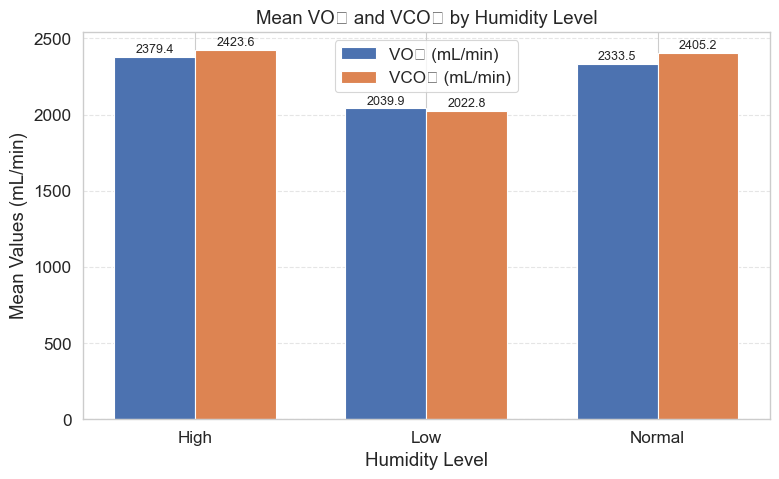

In [537]:
# Create Humidity Category
def categorize_humidity(h):
    if h < 30:
        return 'Low'
    elif h <= 60:
        return 'Normal'
    else:
        return 'High'

# Apply the categorization
combined_df['Humidity_Level'] = combined_df['Humidity'].apply(categorize_humidity)

# Group and calculate means
mean_values = combined_df.groupby('Humidity_Level')[['VO2', 'VCO2']].mean().reset_index()

# Plot multiseries bar chart
x = mean_values['Humidity_Level']
vo2 = mean_values['VO2']
vco2 = mean_values['VCO2']

bar_width = 0.35
index = range(len(x))

plt.figure(figsize=(8, 5))
vo2_bars = plt.bar(index, vo2, bar_width, label='VO₂ (mL/min)')
vco2_bars = plt.bar([i + bar_width for i in index], vco2, bar_width, label='VCO₂ (mL/min)')

# Setting lables to vo2 bars
for bar in vo2_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Setting lables to vco2 bars
for bar in vco2_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.xlabel('Humidity Level')
plt.ylabel('Mean Values (mL/min)')
plt.title('Mean VO₂ and VCO₂ by Humidity Level')
plt.xticks([i + bar_width / 2 for i in index], x)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Analysis Summary:
##### <i>Based on mean values among different humidity level, Oxygen consumption(vo2) and Carbon Dioxide Output(vco2) values are lower in low humidity and higher in normal and high humidity level this shows that low humidity may reduce respiratory and cardiovascular stress during exercise, while high humidity increases the <br>physiological load, leading to greater oxygen utilization and metabolic output.</i> 

### 22. "Display the average speed of each participant  in ' peak exercise' based on RER (Following question no.14)"



In [541]:
test1= test_m
test1['RER'] =test1['VCO2']/test1['VO2']
test1['RER']=test1['RER'].fillna(test1['RER'].mean())
test1.sort_values("RER", inplace=True)
#assuming the RER range from warmup, moderate and peak exercise as 0.5-0.85- 1
#warmup -0.5 to 0.85
#moderate - 0.85 - 1
#peak greater than 1
def categorize(RER):
 if RER >=1 :
    return 'Peak Exercise'
 elif RER >=0.85:
      return 'Moderate Exercise'
 else:
      return 'Warmup'
test1['category'] = test1['RER'].apply(categorize)

# Filter data where RER >= 1.0 (peak exercise condition)
peak_exercise = test_m[test_m['RER'] >= 1.0]

# Group by participant ID and calculate average speed
avg_speed_peak = peak_exercise.groupby('ID')['Speed'].mean().reset_index(name='Avg_Speed_Peak_Exercise')

# Display the result
print("Average Speed During Peak Exercise (RER ≥ 1.0):")
print(avg_speed_peak)


Average Speed During Peak Exercise (RER ≥ 1.0):
      ID  Avg_Speed_Peak_Exercise
0      1                 9.892920
1      2                10.850575
2      3                12.000597
3      4                10.787342
4      5                 9.007265
..   ...                      ...
852  853                 8.858986
853  854                 6.149524
854  855                12.110079
855  856                10.712664
856  857                10.231186

[857 rows x 2 columns]


### 23."Assign one of the following 5 heart rate zones for every Athletes  and add this as a column to a new table with all unique IDs. <br> Exclude Warm-Up Phase
Zone 1 (recovery/easy)       <100 HR max
<br> Zone 2 (aerobic/base)        100-120 HR max
<br>Zone 3 (tempo)        120-135 HR max
<br>Zone 4 (lactate threshold)        135-155 HR max
<br>Zone 5 (anaerobic)        155+ HR max and above"""

In [544]:
# excluding warm up phase, based on time(assuming warm-up is first 60 seconds)
filtered = test_m[test_m['time'] > 30]

# Get Mean HR per athlete
mean_hr_by_id = filtered.groupby('ID')['HR'].mean().reset_index()
mean_hr_by_id.rename(columns={'HR': 'Mean_HR'}, inplace=True)

# Define function to assign heart rate zone
def assign_hr_zone(hr):
    if hr < 100:
        return 'Zone 1 (Recovery/Easy)'
    elif hr < 120:
        return 'Zone 2 (Aerobic/Base)'
    elif hr < 135:
        return 'Zone 3 (Tempo)'
    elif hr < 155:
        return 'Zone 4 (Lactate Threshold)'
    else:
        return 'Zone 5 (Anaerobic)'

# Apply the zone function
mean_hr_by_id['HR_Zone'] = mean_hr_by_id['Mean_HR'].apply(assign_hr_zone)

# unique athletes with their mean HR and assigned zone
print(f"Number of Unique IDs: {test_m['ID'].nunique()}")
print(mean_hr_by_id)


Number of Unique IDs: 857
      ID     Mean_HR                     HR_Zone
0      1  133.051327              Zone 3 (Tempo)
1      2  139.535836  Zone 4 (Lactate Threshold)
2      3  169.722504          Zone 5 (Anaerobic)
3      4  153.936508  Zone 4 (Lactate Threshold)
4      5  159.785589          Zone 5 (Anaerobic)
..   ...         ...                         ...
852  853  167.138702          Zone 5 (Anaerobic)
853  854  107.978967       Zone 2 (Aerobic/Base)
854  855  133.969547              Zone 3 (Tempo)
855  856  129.504905              Zone 3 (Tempo)
856  857  168.656504          Zone 5 (Anaerobic)

[857 rows x 3 columns]


### 24. Find the athlete who has got optimal respiratory stability based on the measure of  Breathing Interval variability over time.

In [547]:
# RR field has 3.4% null values, interpolating RR values
test_m['RR'] = test_m.groupby('ID')['RR'].transform(lambda x: x.interpolate().ffill().bfill())
test_m['RR'].isna().sum()

# Breathing Interval in seconds
filtered = test_m.copy()
filtered['RR_Seconds'] = 60 / filtered['RR']

# Calculating Standard Deviation for each participant based on breathing interval(secs)
stand_dev = filtered.groupby('ID')['RR_Seconds'].std().reset_index()
filtered.rename(columns = {'RR_Seconds' : 'RR_Seconds_std'}, inplace = True)

# Finding the minimum standard deviation value of RR(sec's) to identify the steady and consistent breathing
optimal_athlete_row = filtered.loc[filtered['RR_Seconds_std'].idxmin()]
print(f"Optimal Respiratory Stability Participant id is: {optimal_athlete_row['ID']}")

Optimal Respiratory Stability Participant id is: 437


### 25. Generate a pie chart to show the gender-wise distribution of athletes.

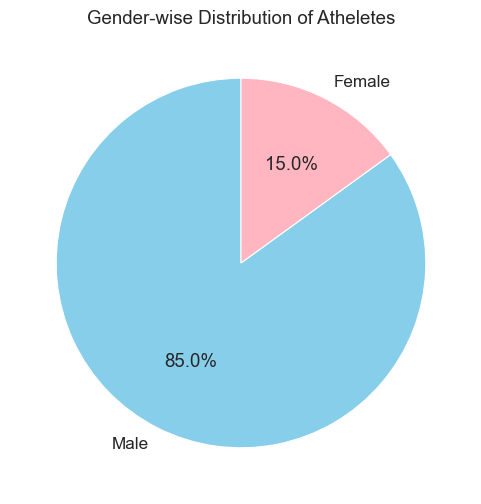

In [550]:
# Count gender distribution
gender_counts = subject_i['Sex'].value_counts()

# Assigning lables
lables = ['Male', 'Female']

# Plotting Pie chart
plt.figure(figsize=(6,6))
plt.pie(gender_counts, 
        labels = lables, 
        autopct ="%1.1f%%", 
        startangle = 90, 
        colors =['skyblue', 'lightpink']
       )
plt.title("Gender-wise Distribution of Atheletes")
plt.show()

### 26. Use enumeration to print ID, Sex, and BMI of each athlete.

In [554]:
#subject_i.columns

In [556]:
# Enumerate() adds counter to any iterables, we can access both item and index
output = ""


for i, row in enumerate(subject_df.itertuples(index=False), start=1):
    output += f"{i}. ID: {row.ID} | Sex: {'Male' if row.Sex == 'Male' else 'Female'} | BMI: {row.BMI}<br>"
    #print(i, row)

# Wrap the entire output in a scrollable div
display(HTML(f"""
<div style="height:300px; overflow:auto; border:1px solid #ccc; padding:10px; font-family:monospace;">
{output}
</div>
"""))


### 27. Create a sunburst chart to show the distribution of athletes based on Sex, BMI levels, and Age ranges.

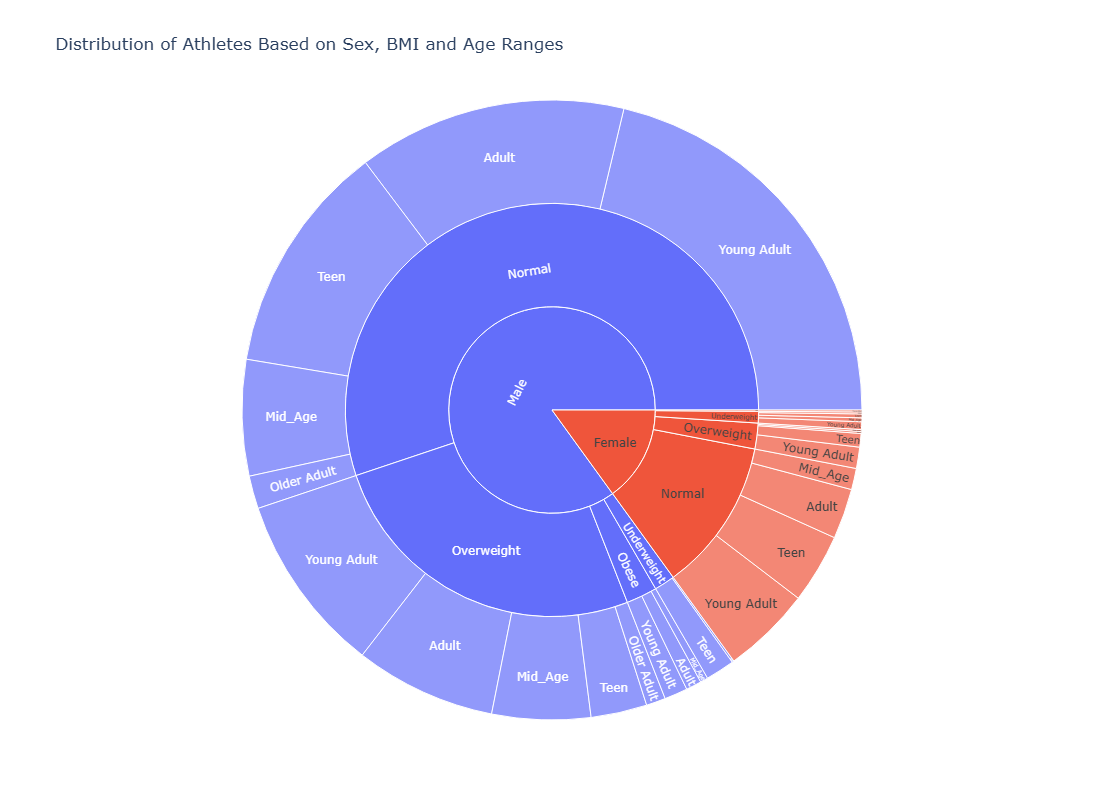

In [559]:
# Dropping null values 
subject_df1 = subject_df.copy()
subject_df1 = subject_df1.dropna(subset = ['Sex', 'BMI', 'Age'])

# Convert 0, 1 to Male, Female
subject_df1['Sex'] = subject_df1['Sex'].map({0: 'Male', 1: 'Female'})

# Categorize BMI levels
def categ_bmi(bmi):
     if bmi < 18.5:
        return 'Underweight'
     elif bmi < 25:
        return 'Normal'
     elif bmi < 30:
        return 'Overweight'
     else:
        return 'Obese'

subject_df1['BMI_level'] = subject_df1['BMI'].apply(categ_bmi)

# Categorize age range
def categ_age(age):
    if age < 20:
        return 'Teen'
    elif age < 30:
        return 'Young Adult'
    elif age < 40:
        return 'Adult'
    elif age < 50:
        return 'Mid_Age'
    else:
        return 'Older Adult'

subject_df1['Age_range'] = subject_df1['Age'].apply(categ_age)

# Plotting sunburst chart
fig = px.sunburst(subject_df1,
                  path = ['Sex', 'BMI_level', 'Age_range'],
                  values = None,
                  title = 'Distribution of Athletes Based on Sex, BMI and Age Ranges'
                )

# Increase the size of the chart
fig.update_layout( width =800,
                  height = 800
                 )
fig.show()


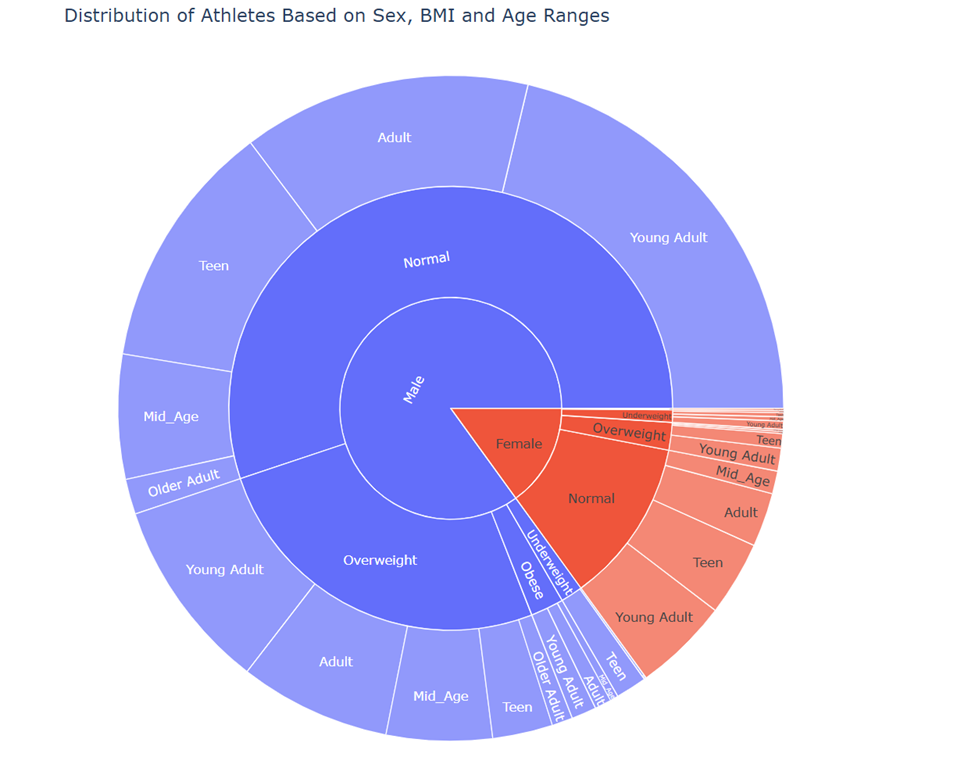

### 28."Create a dictionary using any 5 random Athletes ID and their height. <br>Access any one height using the Athlete ID with get() function. "

In [564]:
# Getting random 5 records
sample_df = subject_i[['ID', 'Height']].dropna().sample(5, random_state = 42)

# Converting into a Dictionary
sample_df_dict = dict(zip(sample_df['ID'], sample_df['Height']))
print("Athlete Height Dictionary--> \nID: Height")
print(sample_df_dict)

# Pick one ID from dictionary
sample_keys = list(sample_df_dict.keys())[0]

# Getting height Using get() function 
height = sample_df_dict.get(sample_keys)
print(f"Height of Athlete with ID {sample_keys} is : {height} cm")

Athlete Height Dictionary--> 
ID: Height
{801: 172.6, 741: 168.4, 800: 179.0, 552: 186.0, 440: 173.0}
Height of Athlete with ID 801 is : 172.6 cm


### 29.Find which age range has the highest number of obese athletes.

In [567]:
# Getting obese count
obese_counts = subject_df1[subject_df1['BMI_level'] == 'Obese'].groupby('Age_range').size()

# Getting the age range that has the maximum obesity count
max_age_range = obese_counts.idxmax()
max_count = obese_counts.max()
print(f"{max_age_range} has the highest({max_count}-count) Obesity")

Young Adult has the highest(13-count) Obesity


### 30. "Create a waffle chart to show the percentage of participant in each HR zone (followed by question 23)"

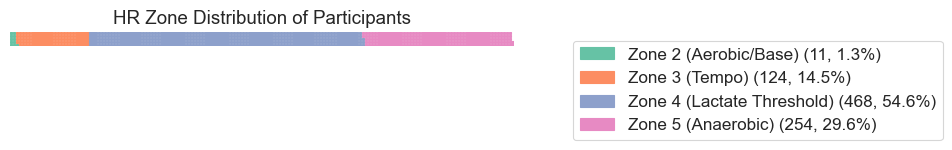

In [570]:
zone_counts = mean_hr_by_id['HR_Zone'].value_counts().sort_index()

# Create a Waffle Chart
labels = [
    f"{zone} ({count}, {count / zone_counts.sum() * 100:.1f}%)"
    for zone, count in zone_counts.items()
         ]
fig = plt.figure(
    FigureClass = Waffle,
    rows = 5,  
    values = zone_counts,
    title = {'label': 'HR Zone Distribution of Participants', 'loc': 'center'},
    labels = labels,
    legend = {'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)},
    figsize  =(10, 5),
)

plt.show()

### 31. Calculate the Tidal volume of every athlete and display it as a list.

In [573]:
# Exclude rows where VE or RR is missing or RR is zero
filtered = test_m[(test_m['VE'].notna()) & (test_m['RR'].notna()) & (test_m['RR'] > 0)].copy()

# Calculate Tidal Volume
filtered['Tidal_Volume_L'] = filtered['VE'] / filtered['RR']  # Result in Liters per breath

# Converting to mL 
filtered['Tidal_Volume_mL'] = filtered['Tidal_Volume_L'] * 1000

# Display as list (average tidal volume per athlete)
tidal_volume_list = round(filtered.groupby('ID')['Tidal_Volume_mL'].mean().reset_index(),1)

print("Average Tidal Volume per Athlete (in mL):")
print(tidal_volume_list)


Average Tidal Volume per Athlete (in mL):
      ID  Tidal_Volume_mL
0      1           2027.3
1      2           1373.2
2      3           1599.5
3      4           2188.3
4      5           1934.5
..   ...              ...
852  853           1730.4
853  854           2395.3
854  855           1641.0
855  856           2098.7
856  857           2060.4

[857 rows x 2 columns]


### 32.create a Pivot table to summarize the count of each HR Zone

In [576]:
print(mean_hr_by_id.nunique())
# Create a pivot table to count athletes in each HR Zone
hr_zone_pivot = pd.pivot_table(
    mean_hr_by_id,
    index='HR_Zone',         # Group by HR Zone
    values='ID',             # Count IDs
    aggfunc='count'          # Count how many athletes in each zone
)

# Rename column
hr_zone_pivot.rename(columns={'ID': 'Athlete_Count'}, inplace=True)

# Display the pivot table
print(hr_zone_pivot)



ID         857
Mean_HR    857
HR_Zone      4
dtype: int64
                            Athlete_Count
HR_Zone                                  
Zone 2 (Aerobic/Base)                  11
Zone 3 (Tempo)                        124
Zone 4 (Lactate Threshold)            468
Zone 5 (Anaerobic)                    254


### 33.Connect to database using PostgresSQL and increase the temperature 2 degree for participant with maximum humidity and display the result

In [579]:
import psycopg2

conn = psycopg2.connect(
    dbname="subject_info",
    user="postgres",
    password="pgdb",
    host="localhost",
    port="5432"
)

cur = conn.cursor()

cur.execute("""
    SELECT ID, Humidity, Temperature
    FROM subject_info
    WHERE Temperature IS NOT NULL
    ORDER BY Humidity DESC
    LIMIT 1;
""")


result = cur.fetchone()

if result:
    id_with_max_humidity = result[0]
    max_humidity = result[1]
    current_temperature = result[2]

    print(f"Participant ID: {id_with_max_humidity}, Max Humidity: {max_humidity}, Current Temperature: {current_temperature}")

    simulated_temperature = current_temperature + 2

    print(f"Temperature increased to {simulated_temperature}° for Participant ID: {id_with_max_humidity}")

   
    cur.execute("""
        SELECT ID, Age, Weight, Height, Humidity, Temperature, Sex, ID_test
        FROM subject_info
        WHERE ID = %s;
    """, (id_with_max_humidity,))

    original_result = cur.fetchone()
    if original_result:
       
        result = list(original_result)
        result[5] = simulated_temperature  

        print("Updated participant info:")
        print(tuple(result))  

cur.close()
conn.close()

OperationalError: connection to server at "localhost" (::1), port 5432 failed: FATAL:  password authentication failed for user "postgres"


### 34.Create an array, np.arrange.reshape(3,4). Replace the array elements with their square values if the element is an even Number. Keep the odd numbers as such. Displaying the resulting array.

In [582]:
arr = np.arange(12).reshape(3, 4)
result = np.where(arr % 2 == 0, arr ** 2, arr)

print("Original array:\n", arr)
print("\n Resulting array (even numbers squared):\n", result)

Original array:
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

 Resulting array (even numbers squared):
 [[  0   1   4   3]
 [ 16   5  36   7]
 [ 64   9 100  11]]


### 35. Read 10 records from dataframe and convert into Json format and print the data

In [585]:
subset_df = test_m.head(10)

# Convert the dataframe to JSON format
json_data = subset_df.to_json(orient='records')

# Print the JSON data
print(json.dumps(json.loads(json_data), indent=4))

[
    {
        "time": 60,
        "Speed": 5.0,
        "HR": 66.0,
        "VO2": 678.0,
        "VCO2": 344.0,
        "RR": 25.0,
        "VE": 17.2,
        "ID_test": "305_1",
        "ID": 305,
        "RER": 0.5073746313,
        "category": "Warmup"
    },
    {
        "time": 0,
        "Speed": 5.0,
        "HR": 84.0,
        "VO2": 821.0,
        "VCO2": 417.0,
        "RR": 20.0,
        "VE": 13.3,
        "ID_test": "330_1",
        "ID": 330,
        "RER": 0.5079171742,
        "category": "Warmup"
    },
    {
        "time": 68,
        "Speed": 5.0,
        "HR": 64.0,
        "VO2": 660.0,
        "VCO2": 337.0,
        "RR": 24.0,
        "VE": 16.7,
        "ID_test": "305_1",
        "ID": 305,
        "RER": 0.5106060606,
        "category": "Warmup"
    },
    {
        "time": 72,
        "Speed": 5.0,
        "HR": 114.0,
        "VO2": 998.0,
        "VCO2": 510.0,
        "RR": 23.0,
        "VE": 17.8,
        "ID_test": "518_1",
        "ID": 518,
   

### 36. Create a Barchart in HR vs count and apply hatches to the bars? # recheck

{'Zone 1': 57869, 'Zone 2': 75458, 'Zone 3': 66309, 'Zone 4': 104889, 'Zone 5': 269460}


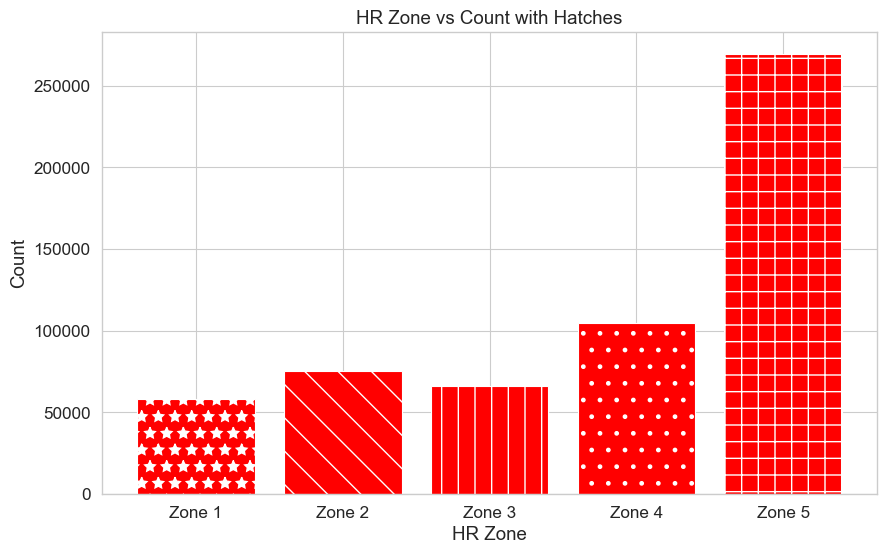

In [588]:
zones = {
    'Zone 1': test_m[test_m['HR'] < 100],
    'Zone 2': test_m[(test_m['HR'] >= 100) & (test_m['HR'] <= 120)],
    'Zone 3': test_m[(test_m['HR'] > 120) & (test_m['HR'] <= 135)],
    'Zone 4': test_m[(test_m['HR'] > 135) & (test_m['HR'] <= 155)],
    'Zone 5': test_m[test_m['HR'] > 155]
}

counts = {zone: len(data) for zone, data in zones.items()}
print(counts)


df = pd.DataFrame({
    'HR Zone': list(counts.keys()),
    'Count': list(counts.values())
})

hatches = ['*', '\\', '|', '.', '+']


plt.figure(figsize=(10, 6))
bars = plt.bar(df['HR Zone'], df['Count'], color='red')


for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.xlabel('HR Zone')
plt.ylabel('Count')
plt.title('HR Zone vs Count with Hatches')


plt.show()


### 37. Who is the youngest athlete and how many tests did she take part in?


In [591]:
subject_i['Sex'] = subject_i['Sex'].replace({0: 'Male', 1: 'Female'})

In [593]:
youngest_athlete = subject_i.loc[subject_i['Age'].idxmin()]

youngest_athlete_id = youngest_athlete['ID']
youngest_athlete_age = youngest_athlete['Age']
youngest_athlete_test_id = youngest_athlete['ID_test']

youngest_tests = test_m[test_m['ID_test'] == youngest_athlete_test_id]

num_tests = len(youngest_tests)

print(f"The youngest athlete ID is  {youngest_athlete_id}.")
print(f"Her age is {youngest_athlete_age}.")
print(f"She took part in {num_tests} tests.")


The youngest athlete ID is  543.
Her age is 10.8.
She took part in 676 tests.


### 38. Plot the changes in HR and VO2 over time for each ID_Test. Add a trendline to compare the HR and VO2 changes.

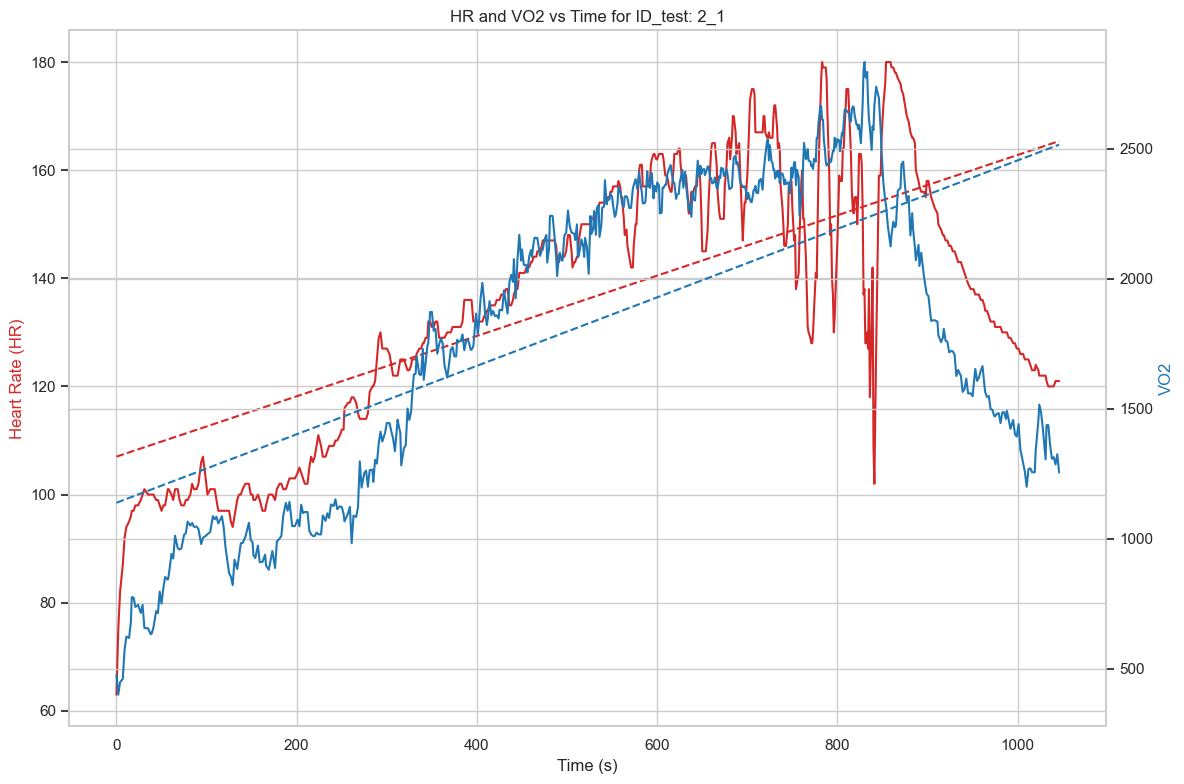

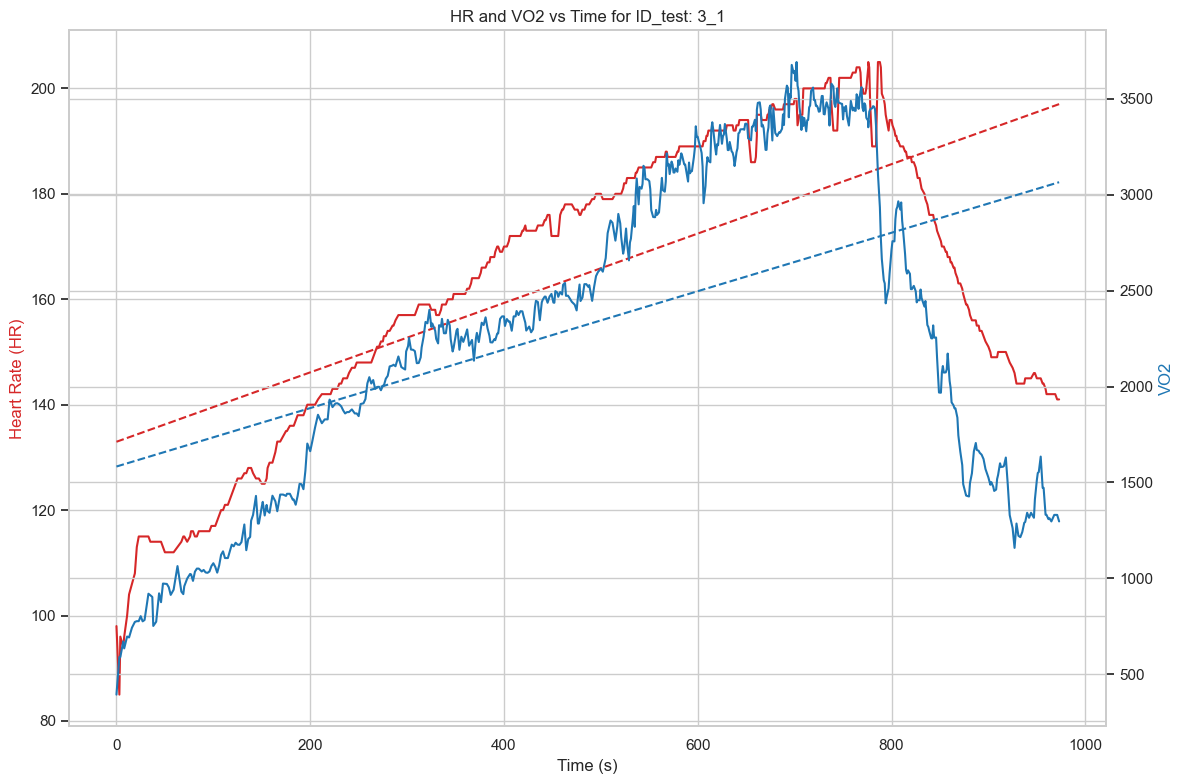

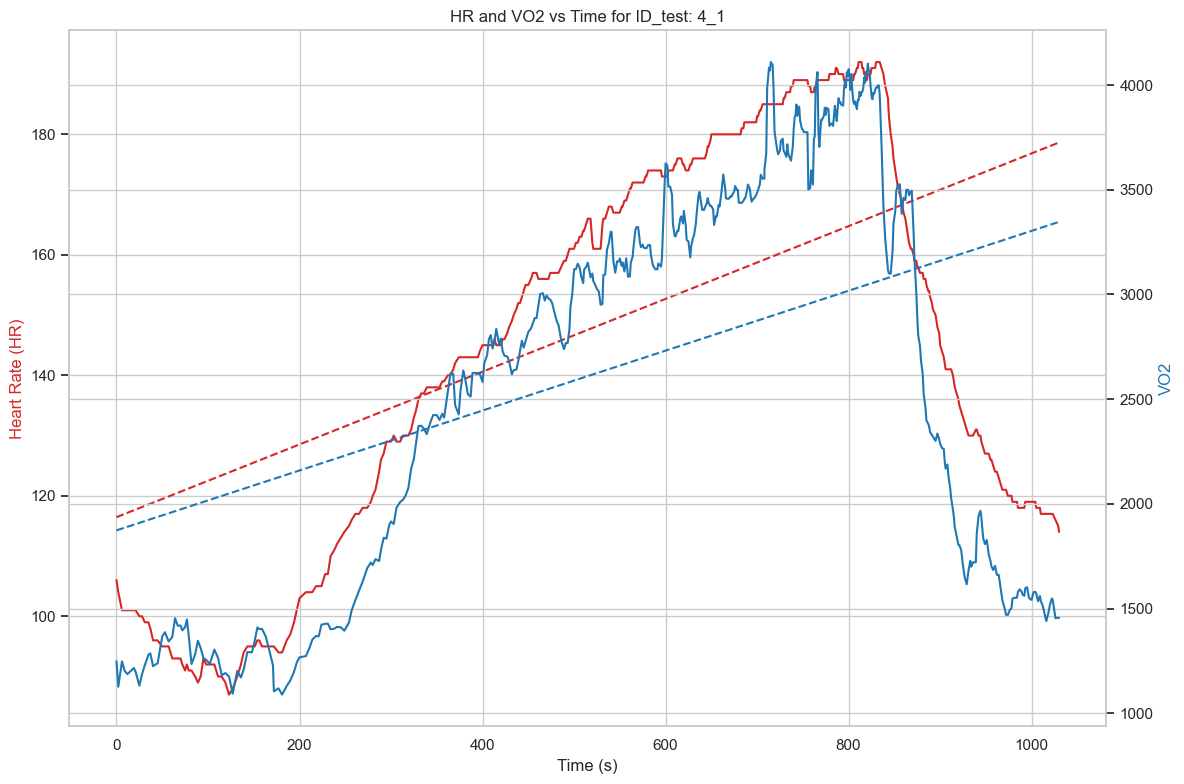

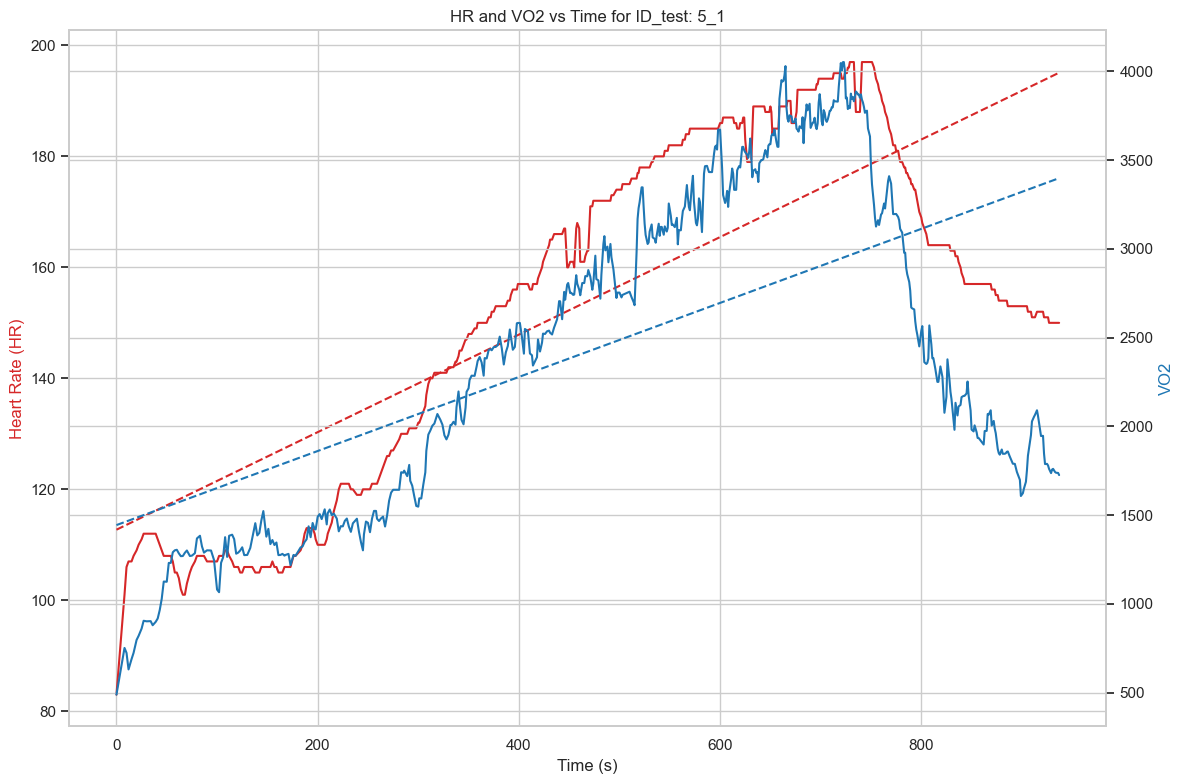

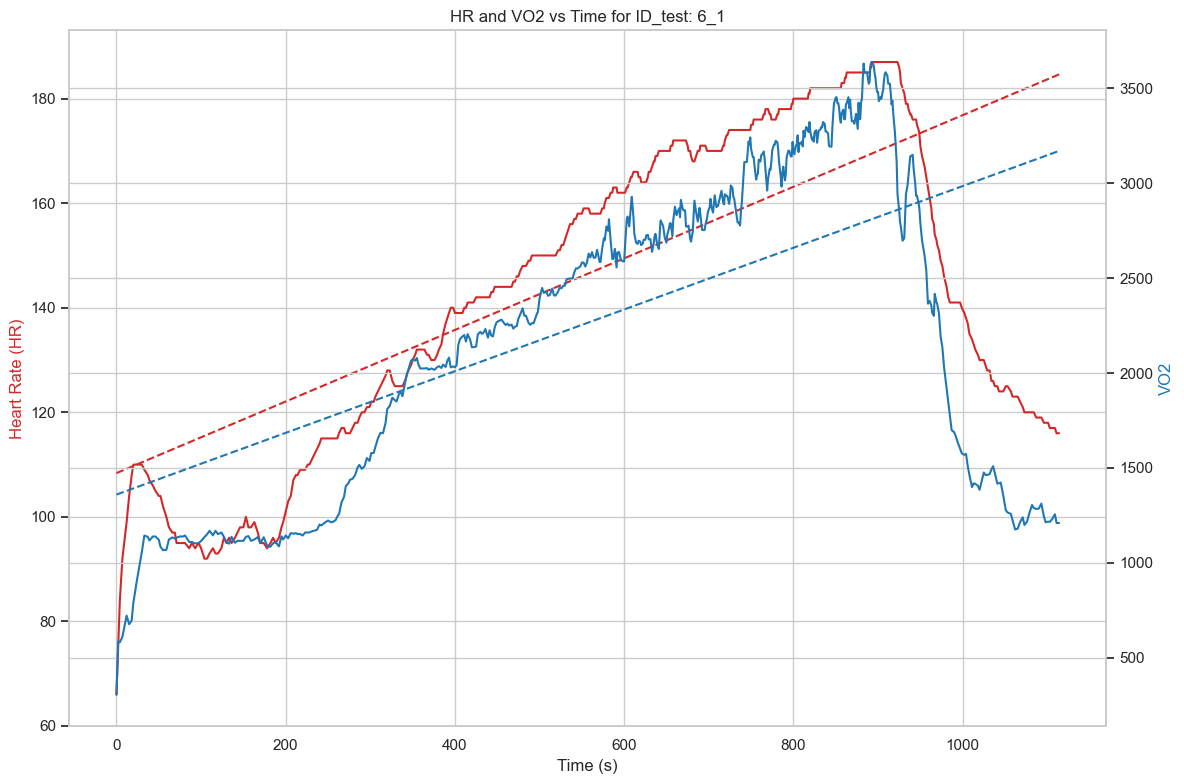

Plotting last 5 test IDs


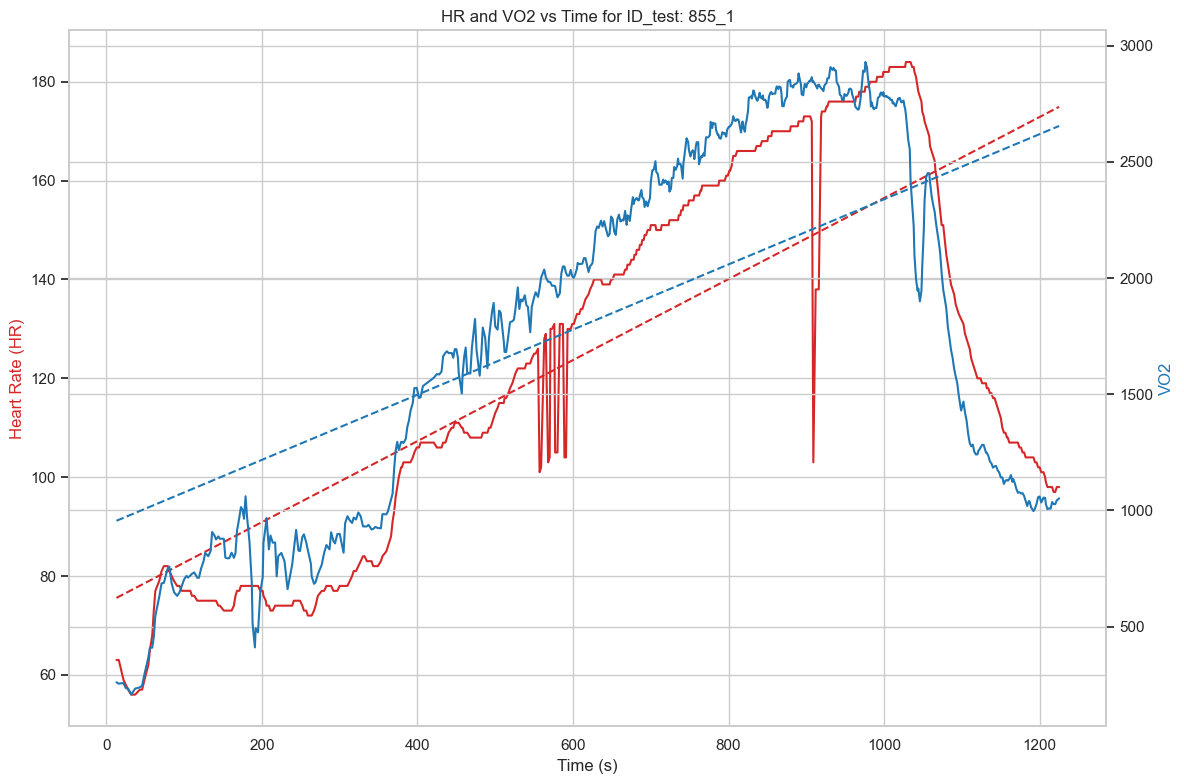

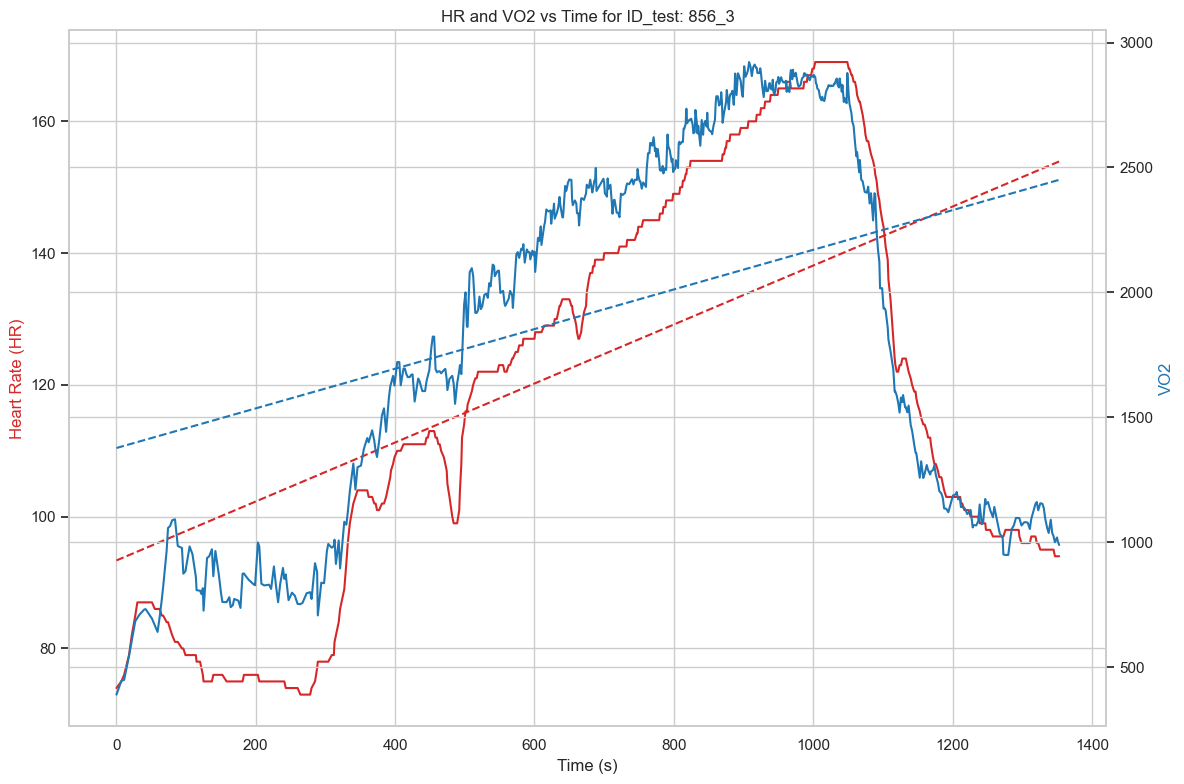

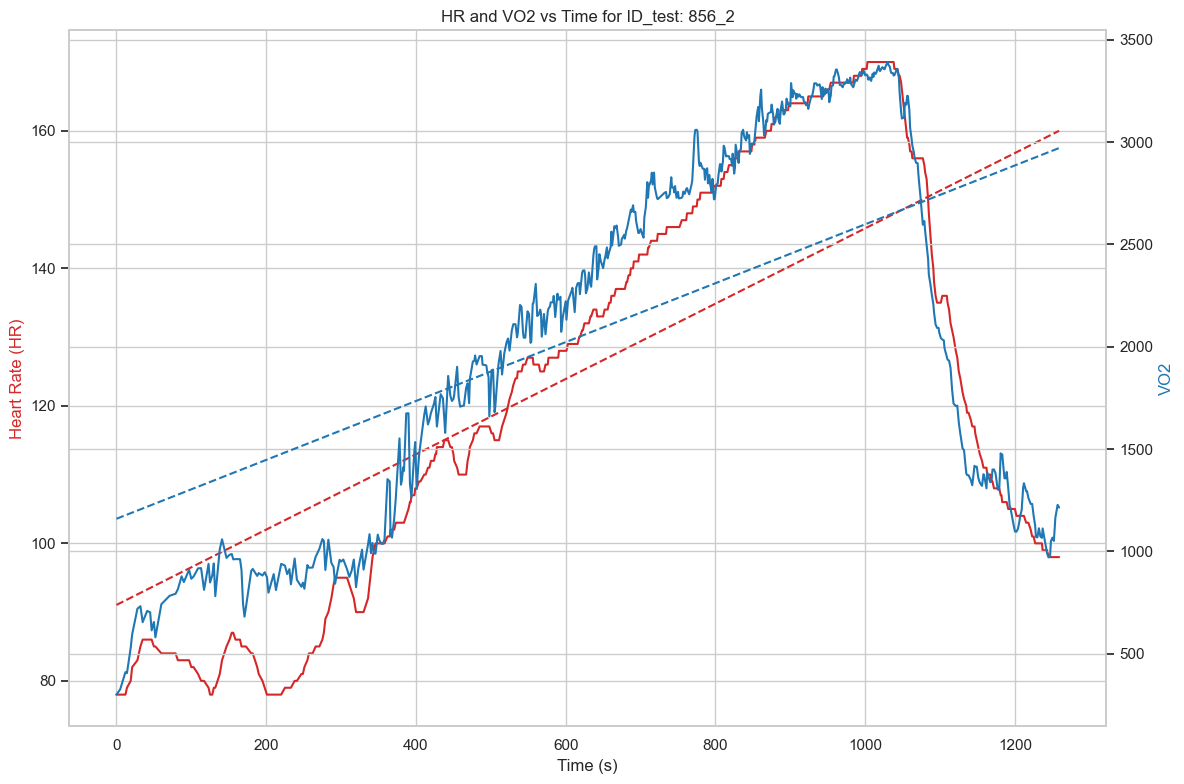

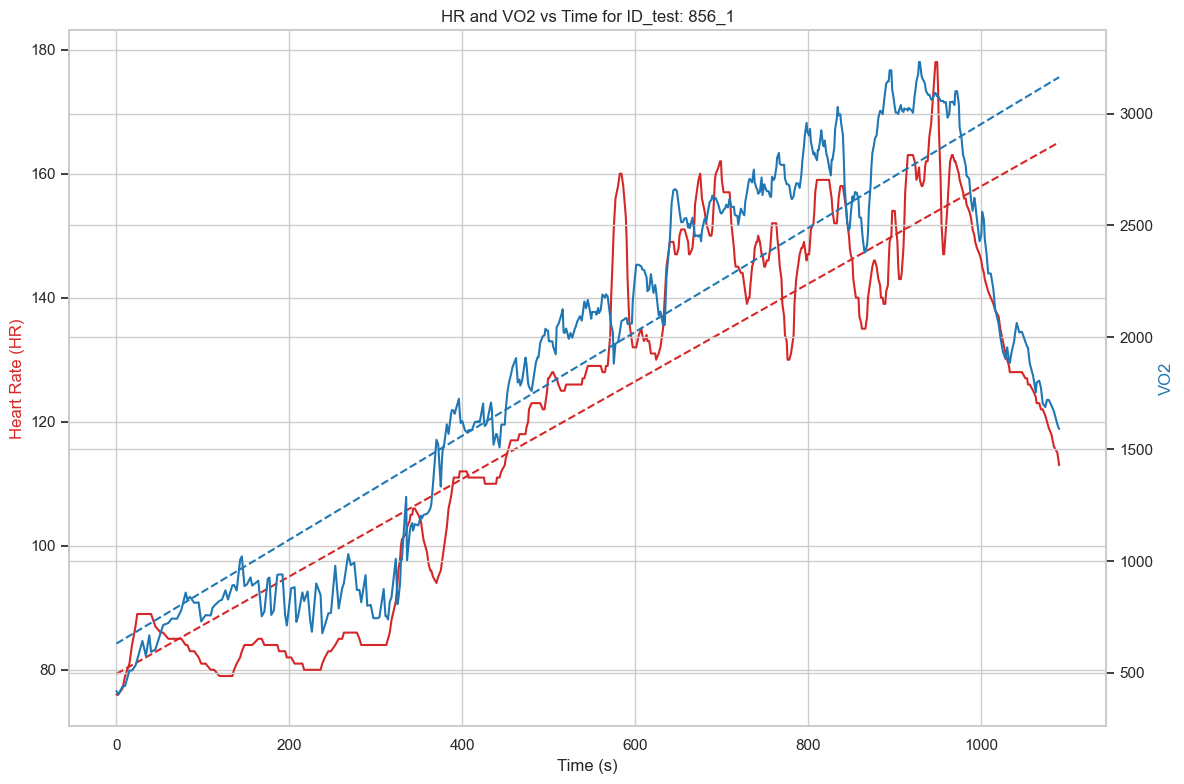

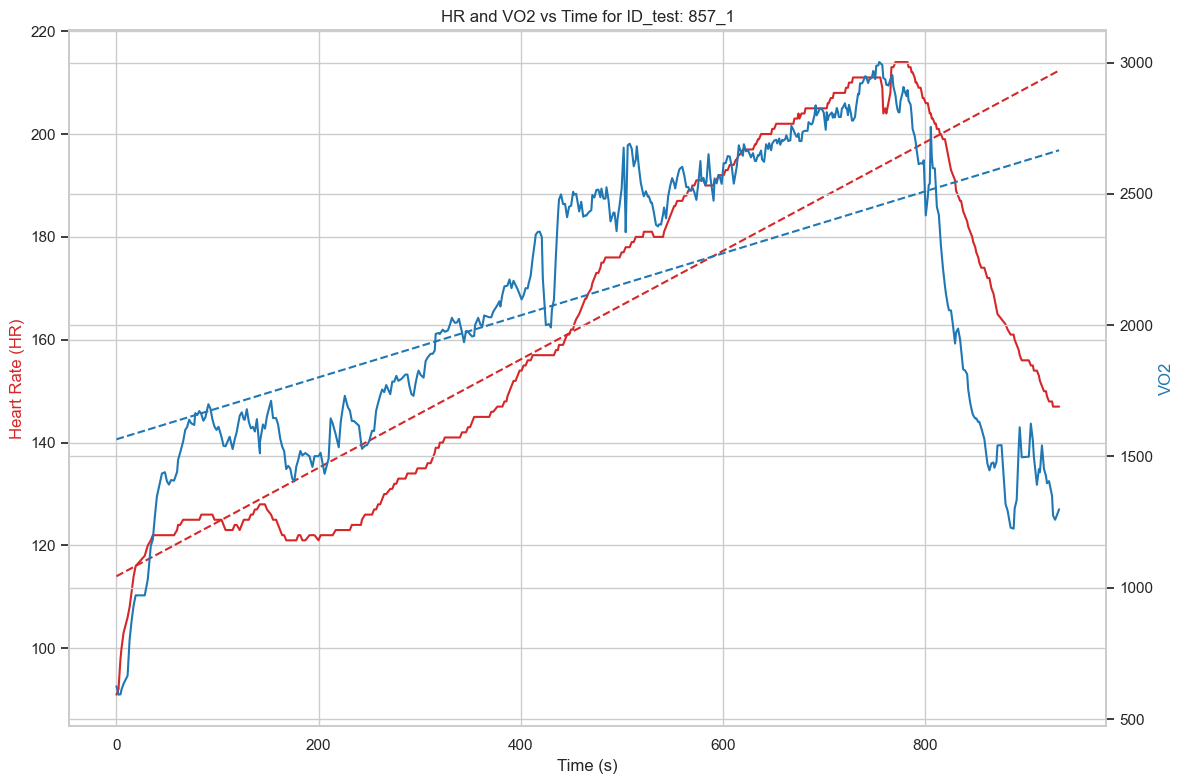

In [797]:
test_m = test_m.dropna(subset=['HR', 'VO2'])

# Set seaborn style
sns.set(style="whitegrid")

# Function to plot dual-axis chart with trend lines
def plot_dual_axis_with_trend(data, id_test, save_plot=False):
    subset = data[data['ID_test'] == id_test]
    if subset.empty:
        print(f"No valid data for ID_test: {id_test}")
        return

    time = subset['time']
    hr = subset['HR']
    vo2 = subset['VO2']

    fig, ax1 = plt.subplots(figsize=(12, 8))

    color1 = 'tab:red'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Heart Rate (HR)', color=color1)
    ax1.plot(time, hr, color=color1, label='HR')
    z1 = np.polyfit(time, hr, 1)
    p1 = np.poly1d(z1)
    ax1.plot(time, p1(time), color=color1, linestyle='--', label='HR Trend')

    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('VO2', color=color2)
    ax2.plot(time, vo2, color=color2, label='VO2')
    z2 = np.polyfit(time, vo2, 1)
    p2 = np.poly1d(z2)
    ax2.plot(time, p2(time), color=color2, linestyle='--', label='VO2 Trend')

    plt.title(f"HR and VO2 vs Time for ID_test: {id_test}")
    fig.tight_layout()

    if save_plot:
        plt.savefig(f'plot_{id_test}.png')
        plt.close()
    else:
        plt.show()

# Plot only the first 5 unique test IDs
unique_tests = test_m['ID_test'].unique()
for id_test in unique_tests[:5]:  # Just 5 plots
    plot_dual_axis_with_trend(test_m, id_test)

# Last 5
print("Plotting last 5 test IDs")
for id_test in unique_tests[-5:]:
    plot_dual_axis_with_trend(test_m, id_test)


### 39. Find the average HRV for individual athlets, using short-term varaiablity analysis (RMSSD)

In [599]:
test_m = test_m.dropna(subset=['HR'])

test_m = test_m.sort_values(by=['ID', 'time'])

test_m['RR_interval'] = 60000 / test_m['HR']

def calculate_rmssd(rr_intervals):
    rr_diff = np.diff(rr_intervals)
    squared_diff = rr_diff ** 2
    rmssd = np.sqrt(np.mean(squared_diff))
    return rmssd if len(rr_diff) > 0 else np.nan  


rmssd_per_athlete = (
    test_m.groupby('ID')['RR_interval']
    .apply(lambda x: calculate_rmssd(x.values))
    .reset_index()
)


rmssd_per_athlete.columns = ['ID', 'Average_HRV_RMSSD_ms']

print(" Average HRV per Athlete:")
print(rmssd_per_athlete)

 Average HRV per Athlete:
      ID  Average_HRV_RMSSD_ms
0      1              4.926002
1      2             14.001345
2      3              5.866826
3      4              3.504801
4      5              6.152472
..   ...                   ...
841  853              4.066015
842  854             24.244265
843  855             71.699791
844  856             38.203697
845  857              3.010206

[846 rows x 2 columns]


### 40.  Identify the test that took the longest time to complete

In [602]:
longest_test = test_m.loc[test_m['time'].idxmax()]
longest_test_id = longest_test['ID_test']
time_taken = longest_test['time']
print(f"The test that took the longest time ID_Test: {longest_test_id}")
print(f"Duration of the longest test: {time_taken} seconds")

The test that took the longest time ID_Test: 699_1
Duration of the longest test: 1712 seconds


### 41 Perform an EDA of subject_info using YDATA Profiling

In [605]:
from ydata_profiling import ProfileReport

# Generate the profile report
profile = ProfileReport(subject_i, title="EDA Report of Subject-info")

print("✅ EDA report saved as 'subject_i_EDA_Report.html'")

✅ EDA report saved as 'subject_i_EDA_Report.html'


### 42 How does respiration rate progress based on trendmill speed for different BMI levels? Visualize this relationship and find which BMI level has the highest mean respiration rate?

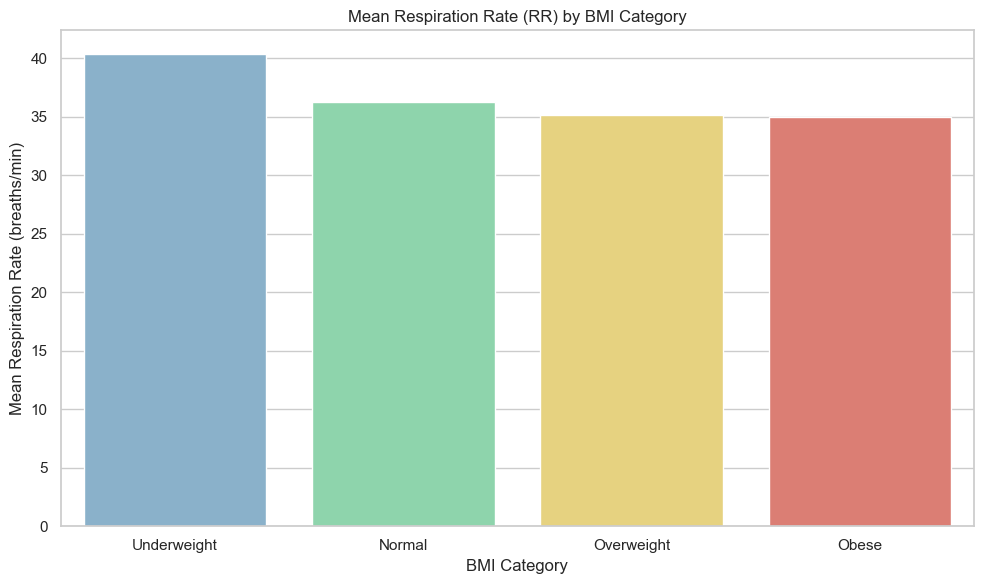


📈 Mean Respiration Rate by BMI Category:
  BMI_Category         RR
0  Underweight  40.378981
1       Normal  36.286229
2   Overweight  35.148667
3        Obese  34.998212

🏆 Highest Mean RR: Underweight (40.38 breaths/min)


In [608]:
sns.set(style="whitegrid")

# Calculate BMI
subject_i['Height_m'] = subject_i['Height'] / 100
subject_i['BMI'] = subject_i['Weight'] / (subject_i['Height_m'] ** 2)

def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

subject_i['BMI_Category'] = subject_i['BMI'].apply(bmi_category)
merged_df = pd.merge(test_m, subject_i[['ID', 'BMI_Category']], on='ID')
filtered_df = merged_df.dropna(subset=['RR', 'Speed'])

mean_rr_df = (
    filtered_df.groupby('BMI_Category')['RR']
    .mean()
    .reindex(['Underweight', 'Normal', 'Overweight', 'Obese'])  # for consistent order
    .reset_index()
)

bmi_palette = {
    'Underweight': '#7FB3D5',  # Light blue
    'Normal': '#82E0AA',       # Light green
    'Overweight': '#F7DC6F',   # Yellow
    'Obese': '#EC7063'         # Red/pink
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=mean_rr_df,
    x='BMI_Category',
    y='RR',
    hue='BMI_Category',
    palette=bmi_palette,
    dodge=False,
    legend=False
)

plt.title('Mean Respiration Rate (RR) by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Mean Respiration Rate (breaths/min)')
plt.tight_layout()
plt.show()


print("\n📈 Mean Respiration Rate by BMI Category:")
print(mean_rr_df)

highest = mean_rr_df.loc[mean_rr_df['RR'].idxmax()]
print(f"\n🏆 Highest Mean RR: {highest['BMI_Category']} ({highest['RR']:.2f} breaths/min)")

### 43 Identify cases of possible bradycardia at rest and display number of athletes based on gender

In [611]:
resting_hr = test_m.groupby('ID_test')['HR'].min().reset_index()
resting_hr.rename(columns={'HR': 'Resting_HR'}, inplace=True)

bradycardia_df = resting_hr[resting_hr['Resting_HR'] < 60]

merged = pd.merge(bradycardia_df, subject_i[['ID_test', 'Sex']], left_on='ID_test', right_on='ID_test')

bradycardia_counts = merged['Sex'].value_counts()

print("Bradycardia Cases by Gender (Resting HR < 60 bpm):")
print(bradycardia_counts)

Bradycardia Cases by Gender (Resting HR < 60 bpm):
Sex
Male      130
Female     22
Name: count, dtype: int64


### 44 Calculate the average heart rate corresponding to the speed of the treadmill and plot a line graph to visualize the relationship.

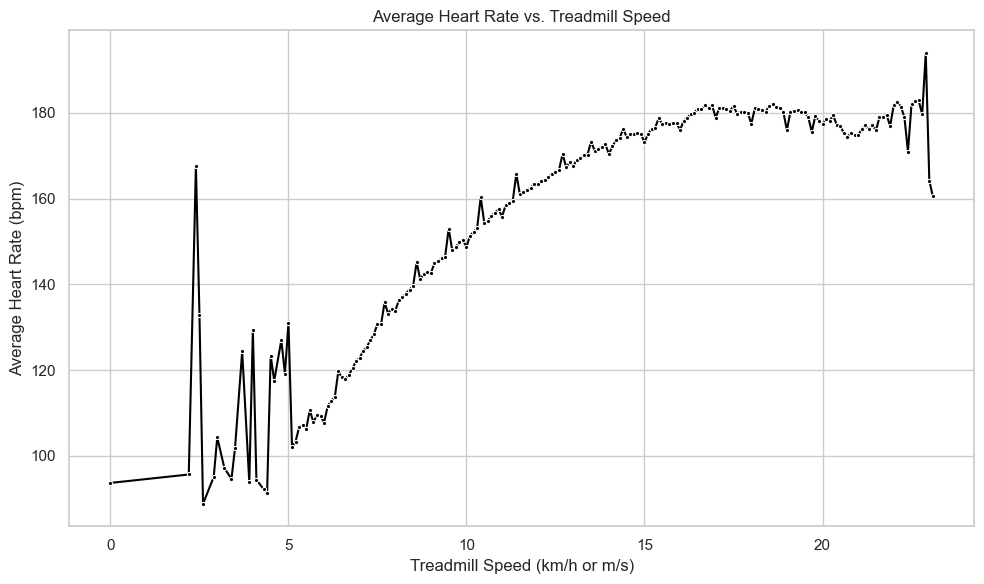

In [614]:
test_m = test_m.dropna(subset=['Speed', 'HR'])
avg_hr_by_speed = test_m.groupby('Speed')['HR'].mean().reset_index()
avg_hr_by_speed = avg_hr_by_speed.sort_values('Speed')
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_hr_by_speed, x='Speed', y='HR', marker='.', color='black')

plt.title('Average Heart Rate vs. Treadmill Speed')
plt.xlabel('Treadmill Speed (km/h or m/s)')
plt.ylabel('Average Heart Rate (bpm)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 45 Analyze the trend of HR at the start of the test vs the middle and the end. What is the overall trend?

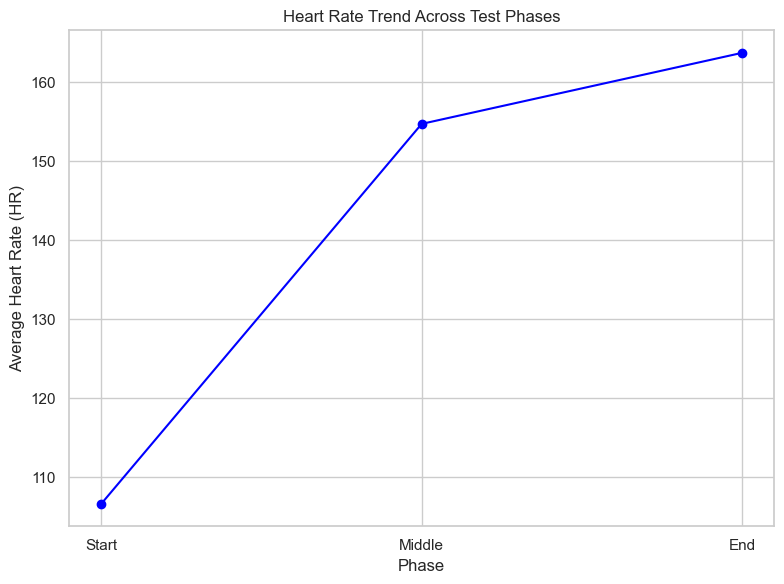

Heart Rate progression from Start to Middle to End phases typically reflects initial adaptation, peak exertion, and recovery.


In [617]:
id_col = test_m['ID_test']

def categorize_phase(group):
    duration = group['time'].max() - group['time'].min()
    group = group.copy()
    group['Phase'] = group['time'].apply(
        lambda t: 'Start' if t <= group['time'].min() + duration / 3 else
                  'Middle' if t <= group['time'].min() + 2 * duration / 3 else
                  'End'
    )
    return group

grouped = test_m[['ID_test', 'time', 'HR']].copy()
result = []

for id_test, group in grouped.groupby('ID_test'):
    categorized = categorize_phase(group)
    result.append(categorized)


test_m = pd.concat(result).reset_index(drop=True)

phase_avg_hr = test_m.groupby('Phase')['HR'].mean().reset_index()

phase_avg_hr['Phase'] = pd.Categorical(phase_avg_hr['Phase'], categories=['Start', 'Middle', 'End'], ordered=True)
phase_avg_hr = phase_avg_hr.sort_values('Phase')

plt.figure(figsize=(8, 6))
plt.plot(phase_avg_hr['Phase'], phase_avg_hr['HR'], marker='o', linestyle='-', color='blue')
plt.title('Heart Rate Trend Across Test Phases')
plt.xlabel('Phase')
plt.ylabel('Average Heart Rate (HR)')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Heart Rate progression from Start to Middle to End phases typically reflects initial adaptation, peak exertion, and recovery.")

### 46. Find the oldest athlete in the dataset and determine the number of breaths recorded for the oldest athlete during the test.

In [619]:
oldest_age = subject_i['Age'].max()
oldest_athlete = subject_i[subject_i['Age'] == oldest_age]

oldest_ids = oldest_athlete['ID_test'].unique()

breath_counts = test_m[test_m['ID_test'].isin(oldest_ids)].shape[0]

print("Oldest Athlete Age:", oldest_age)
print("ID_test:", list(oldest_ids))
print("Number of breaths recorded during the test:", breath_counts)


Oldest Athlete Age: 63.0
ID_test: ['296_1']
Number of breaths recorded during the test: 345


### 47. Assuming age is given for the current year (2025), list the partcipants born on leap year?

In [621]:
# Calculate birth year assuming age given for the current year (2025)
subject_i['birth_year'] = 2025 - subject_i['Age']

 #  Function to check for leap year
def is_leap_year(year):
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

# Filtering the  participants born in a leap year
leap_year_participants = subject_i[subject_i['birth_year'].apply(is_leap_year)]

# Display the result
print(leap_year_participants[['ID', 'Age', 'birth_year']])

      ID   Age  birth_year
113  177  17.0      2008.0
114  303  17.0      2008.0
115  346  17.0      2008.0
116  637  17.0      2008.0
244   83  21.0      2004.0
245  458  21.0      2004.0
246  773  21.0      2004.0
404   84  25.0      2000.0
405  183  25.0      2000.0
406  255  25.0      2000.0
407  263  25.0      2000.0
408  353  25.0      2000.0
409  391  25.0      2000.0
410  493  25.0      2000.0
555  491  29.0      1996.0
556  566  29.0      1996.0
557  857  29.0      1996.0
664  103  33.0      1992.0
665  763  33.0      1992.0
764   95  37.0      1988.0
765  196  37.0      1988.0
766  236  37.0      1988.0
767  253  37.0      1988.0
768  630  37.0      1988.0
769  632  37.0      1988.0
852  101  41.0      1984.0
853  363  41.0      1984.0
917  450  45.0      1980.0


### 48 Use a pairplot to analyze the relationship between temperature, humidity, and VO2 max (ml/kg/min) across different fitness levels. Hint: Classify 'Fitness Level' as 'Low' if VO2 max (ml/kg/min) is below the median, otherwise classify as 'High'

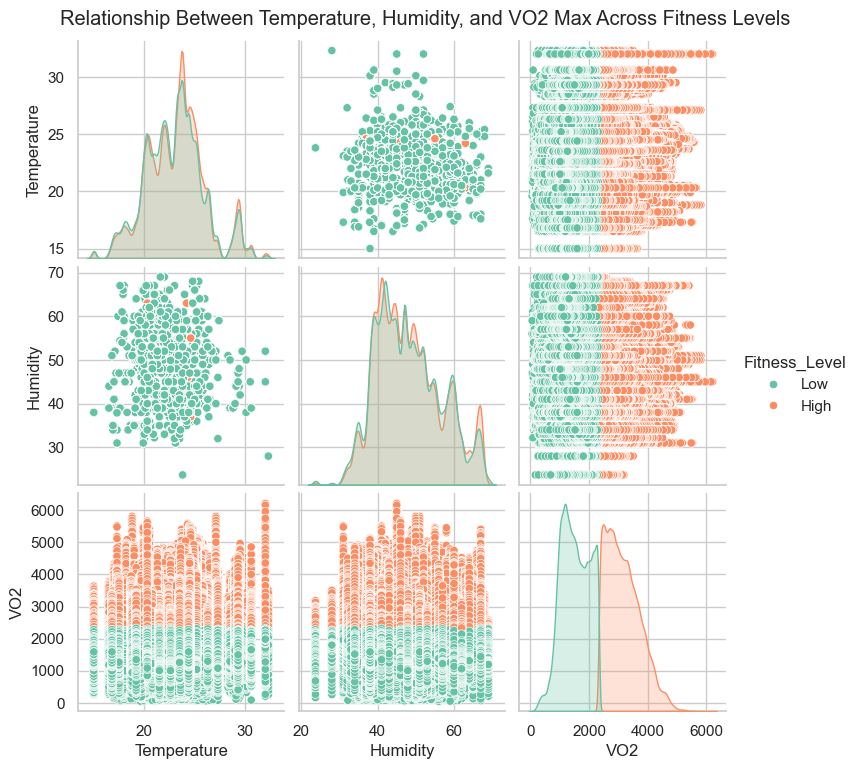

In [623]:
test_m = pd.read_csv('test_measure.csv')
subject_i = pd.read_csv('subject-info.csv')

merged_df = pd.merge(test_m, subject_i, on=['ID', 'ID_test'])



median_vo2 = merged_df['VO2'].median()



merged_df['Fitness_Level'] = merged_df['VO2'].apply(
    lambda vo2: 'Low' if vo2 < median_vo2 else 'High'
)


pairplot_data = merged_df[['Temperature', 'Humidity', 'VO2', 'Fitness_Level']]

sns.pairplot(
    pairplot_data, 
    vars=['Temperature', 'Humidity', 'VO2'], 
    hue='Fitness_Level', 
    diag_kind='kde', 
    palette='Set2'
)

#plt.suptitle("Relationship Between Temperature, Humidity, and VO2 Max Across Fitness Levels", y=1.02)
#plt.show()

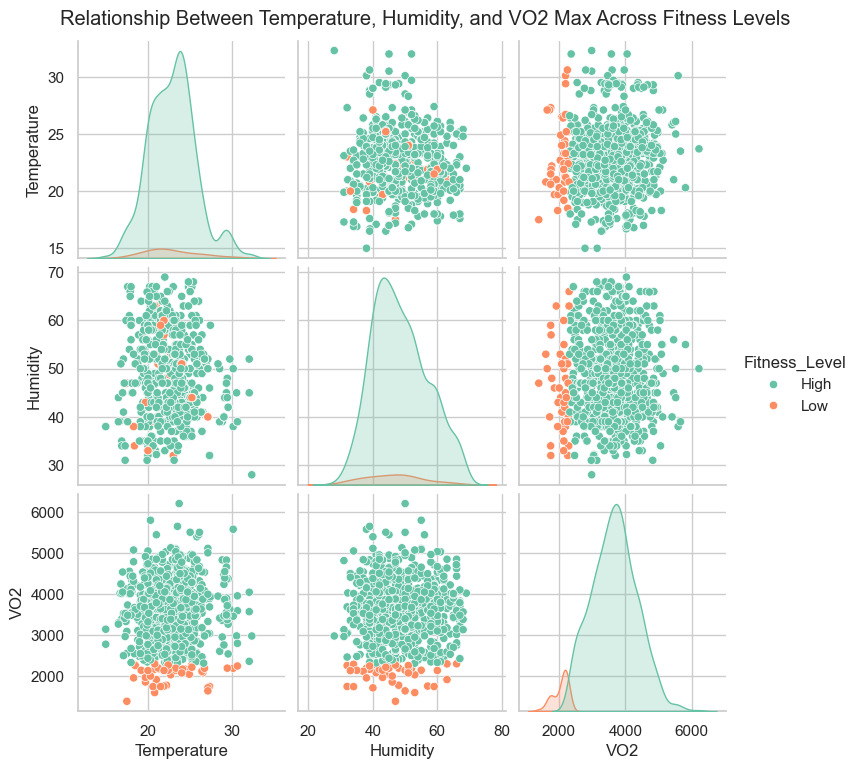

In [640]:
merged_df = pd.merge(test_m, subject_i, on=['ID', 'ID_test'])

median_vo2 = merged_df['VO2'].median()

new_data = merged_df.groupby('ID')['VO2'].max().reset_index()
new_data['meadian_vo2'] = median_vo2



new_data['Fitness_Level'] = new_data['VO2'].apply(
    lambda vo2: 'Low' if vo2 < median_vo2 else 'High'
)


new_data['Temperature']= subject_i['Temperature']
new_data['Humidity']= subject_i['Humidity']

new_data

pairplot_data = new_data[['Temperature', 'Humidity', 'VO2', 'Fitness_Level']]

sns.pairplot(
    pairplot_data, 
    vars=['Temperature', 'Humidity', 'VO2'], 
    hue='Fitness_Level', 
    diag_kind='kde', 
    palette='Set2'
)

plt.suptitle("Relationship Between Temperature, Humidity, and VO2 Max Across Fitness Levels", y=1.02)
plt.show()

In [642]:
pip install altair_viewer  

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [643]:
import altair as alt

### 49 Identify the test name that had the shortest time duration. 

In [647]:
test_measure = pd.read_csv("test_measure.csv")
subject_info = pd.read_csv("subject-info.csv")

# Calculate duration for each test (ID_test)
duration_per_test = test_measure.groupby("ID_test")["time"].agg(["min", "max"])

print(duration_per_test)

duration_per_test["duration"] = duration_per_test["max"] - duration_per_test["min"]

# Identify the test with the shortest duration
shortest_test = duration_per_test["duration"].idxmin()
print(shortest_test)

shortest_duration = duration_per_test.loc[shortest_test, "duration"]

print(f"Test with the shortest duration is '{shortest_test}' with a duration of {shortest_duration} minutes.")


         min   max
ID_test           
100_1      0  1026
101_1      0  1024
102_1      0   870
103_1      0   861
104_1      0  1144
...      ...   ...
98_1       0  1205
99_1       0   927
99_47      0   768
99_54      0   899
9_1        0   895

[992 rows x 2 columns]
564_1
Test with the shortest duration is '564_1' with a duration of 495 minutes.


### 50 What is the percentage difference in mean Carbon dioxide production between male and female athletes?


In [650]:
merged_df = pd.merge(test_measure, subject_info, on='ID')

# Group by 'sex' and calculate the mean of 'VCO2'
mean_vco2_by_sex = merged_df.groupby('Sex')['VCO2'].mean()

# Calculate percentage difference between the means of sex 0 and 1
percentage_difference = ((mean_vco2_by_sex[1] - mean_vco2_by_sex[0]) / mean_vco2_by_sex[0]) * 100

mean_vco2_by_sex, percentage_difference


(Sex
 0    2497.198164
 1    1765.666184
 Name: VCO2, dtype: float64,
 -29.294110102267958)

### 51 Calculate the Fitness Index, generate a bar chart of Fitness Index categories, and export it as SVG file.


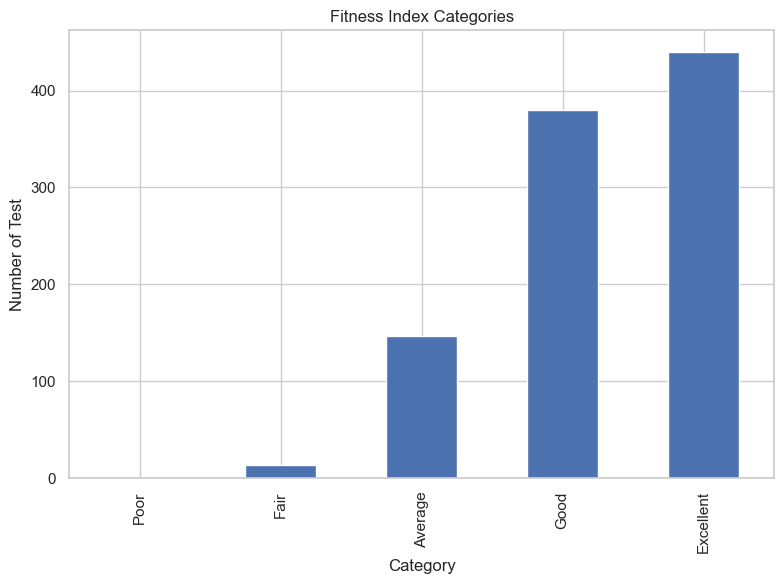

In [653]:
max_vo2 = test_measure.groupby('ID_test')['VO2'].max().reset_index()
max_vo2.rename(columns={'VO2': 'Max_VO2'}, inplace=True)

# Merge with subject info
merged_df = pd.merge(subject_info, max_vo2, on='ID_test')

# Compute Fitness Index = Max_VO2 / Weight
merged_df['Fitness_Index'] = merged_df['Max_VO2'] / merged_df['Weight']

# Categorize Fitness Index into bins
bins = [0, 20, 30, 40, 50, float('inf')]
labels = ['Poor', 'Fair', 'Average', 'Good', 'Excellent']
merged_df['Fitness_Category'] = pd.cut(merged_df['Fitness_Index'], bins=bins, labels=labels)

# Count categories for the bar chart
category_counts = merged_df['Fitness_Category'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.title('Fitness Index Categories')
plt.xlabel('Category')
plt.ylabel('Number of Test')
plt.tight_layout()

plt.savefig("test.svg", format="svg")

plt.show()



### 52 Transpose this numpy matrix. and calculate sum of each row after transposing. 

In [656]:

#Find the row with highest sum(after transposing)

#input array
arr = np.array([[3, 5, 7, 9],
                   [2, 0, 8, 10],
                   [1, 4, 8, 12],
                   [5, 9, 14, 15]])

transposed_arr = arr.T
sum_row = np.sum(transposed_arr, axis=1)
row_max_sum = np.argmax(sum_row)

print("The given matrix:\n", arr)
print("The transposed matrix:\n", transposed_arr)
print("Sum of each row:", sum_row)
print("The row with the highest sum: (index starts with 0)", row_max_sum)

The given matrix:
 [[ 3  5  7  9]
 [ 2  0  8 10]
 [ 1  4  8 12]
 [ 5  9 14 15]]
The transposed matrix:
 [[ 3  2  1  5]
 [ 5  0  4  9]
 [ 7  8  8 14]
 [ 9 10 12 15]]
Sum of each row: [11 18 37 46]
The row with the highest sum: (index starts with 0) 3


### 53 Display participant details with highest average cardiorespiratory fitness in terms of VO2 max.

In [659]:

# Group the test_measure data by 'ID' and calculate the average VO2 per participant
avg_vo2 = test_measure.groupby('ID')['VO2'].mean().reset_index()
avg_vo2.rename(columns={'VO2': 'Average_VO2_Max'}, inplace=True)

# Find the maximum average VO2 max value
max_vo2 = avg_vo2['Average_VO2_Max'].max()

# Filter the participant(s) with the highest average VO2 max
top_participants = avg_vo2[avg_vo2['Average_VO2_Max'] == max_vo2]

# Merge with subject_info to get detailed participant information
result = pd.merge(top_participants, subject_info, on='ID')

result[['ID', 'Average_VO2_Max', 'Age', 'Weight', 'Height', 'Sex']]





ID  Average_VO2_Max   Age  Weight  Height  Sex
0  409      3994.835294  23.6    86.0   190.0    0

### 54 calculate the heart rate reserve and show the distribution as density plot 

In [662]:
# group by ID and get the aggregator for HR min and max

hr_stats_group_by = test_measure.groupby('ID').agg(Rest_HR=('HR', 'min'), Max_HR=('HR', 'max')).reset_index()

# merge HR stats with subject info dataset
merged_df = pd.merge(subject_info, hr_stats_group_by, on='ID', how='inner')

# Calculate the HRR 
merged_df['HRR'] = merged_df['Max_HR'] - merged_df['Rest_HR']

# Display the results in table format with ID, Age, Rest_HR, Max_HR and HRR values
merged_df[['ID', 'Age', 'Rest_HR', 'Max_HR', 'HRR']].head()

ID   Age  Rest_HR  Max_HR    HRR
0  543  10.8     58.0   205.0  147.0
1   11  11.8     96.0   193.0   97.0
2  829  12.2    110.0   195.0   85.0
3  284  13.2     76.0   198.0  122.0
4  341  13.7     81.0   186.0  105.0

### 55 Create a boxplot comparing heart rates between males and females, showing hue as speed category.

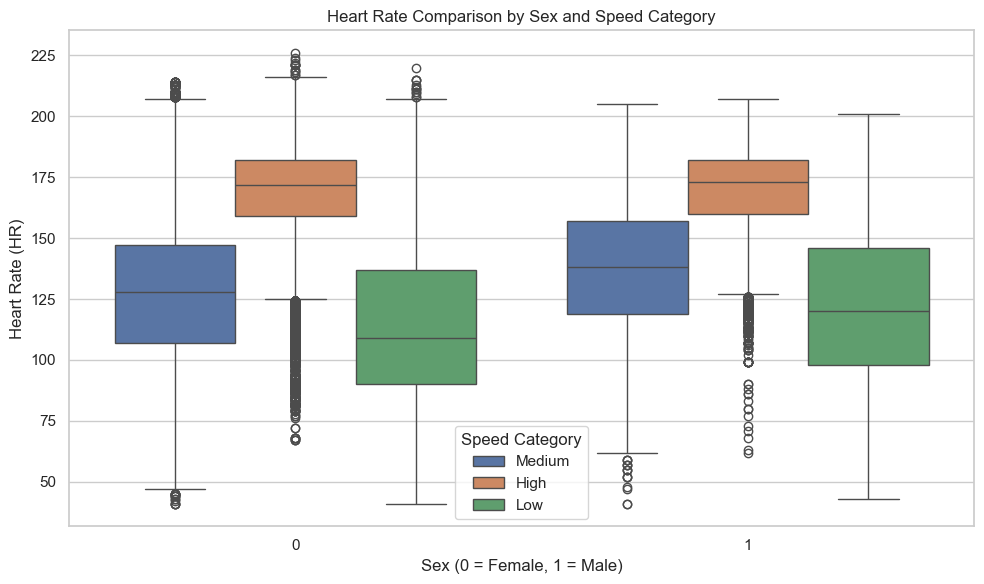

In [665]:
# Merge the two datasets on ID
merged_df = pd.merge(test_measure, subject_info[['ID', 'Sex']], on='ID')

# Create a speed category column category like low < 5, medium 5-10, high > 10
def categorize_speed(speed):
    if speed < 5:
        return 'Low'
    elif speed <= 10:
        return 'Medium'
    else:
        return 'High'

merged_df['Speed_Category'] = merged_df['Speed'].apply(categorize_speed)

# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='HR', hue='Speed_Category', data=merged_df)
plt.title('Heart Rate Comparison by Sex and Speed Category')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Heart Rate (HR)')
plt.legend(title='Speed Category')
plt.tight_layout()
plt.show()

### 56 Choose any feature that follows a Gaussian distribution, convert it into a standard normal distribution, and visualize the results?

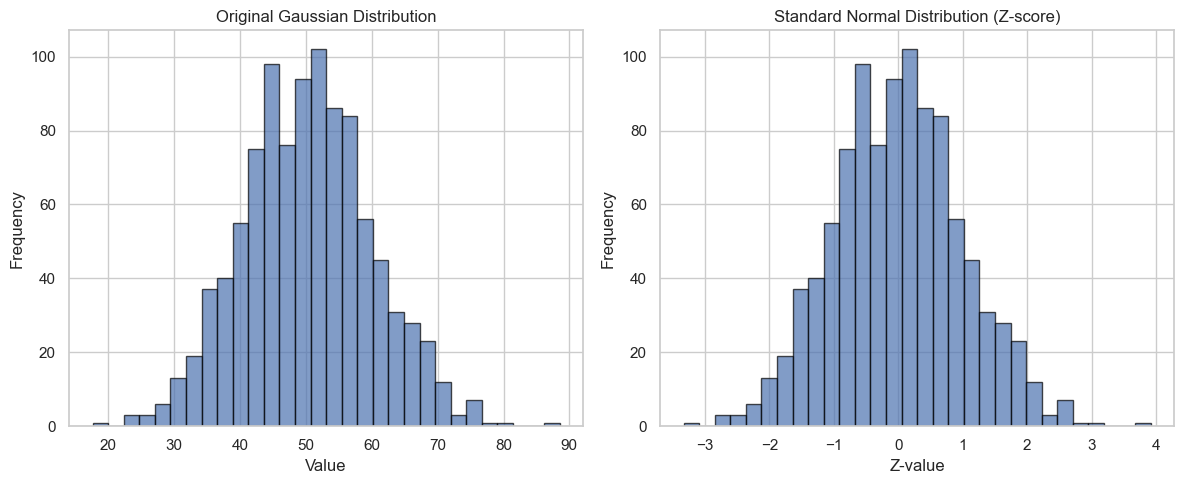

In [668]:
# Create a Gaussian-distributed feature
np.random.seed(42)
data = np.random.normal(loc=50, scale=10, size=1000)  # mean=50, std=10
df = pd.DataFrame({'original_feature': data})

# Convert it to a standard normal distribution 
df['standardized_feature'] = (df['original_feature'] - df['original_feature'].mean()) / df['original_feature'].std()

# Visualize both original and standardized features
plt.figure(figsize=(12, 5))

# Original distribution
plt.subplot(1, 2, 1)
plt.hist(df['original_feature'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Original Gaussian Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Standardized distribution
plt.subplot(1, 2, 2)
plt.hist(df['standardized_feature'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Standard Normal Distribution (Z-score)')
plt.xlabel('Z-value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 57 Identify the participant who has taken maximum number of Graded Exercise test and justify.


In [671]:

subject_info = pd.read_csv('subject-info.csv')
test_measure = pd.read_csv('test_measure.csv')

#total test count
test_counts = test_measure['ID_test'].drop_duplicates().groupby(test_measure['ID']).count()


max_tests = test_counts.max()
top_participant_ids = test_counts[test_counts == max_tests].index


top_participant_details = subject_info[subject_info['ID'].isin(top_participant_ids)]

print(top_participant_details[['ID', 'Age', 'Weight', 'Height']])
print(f"\max tests: {max_tests}")

      ID   Age  Weight  Height
928  506  46.1    72.0   173.0
937  506  46.8    69.5   173.0
945  506  47.7    68.0   173.0
948  506  48.2    70.9   177.2
953  506  49.1    71.5   173.0
\max tests: 5


### 58 For participant ID 725 show trend of  any three variables against time in a single canva ?

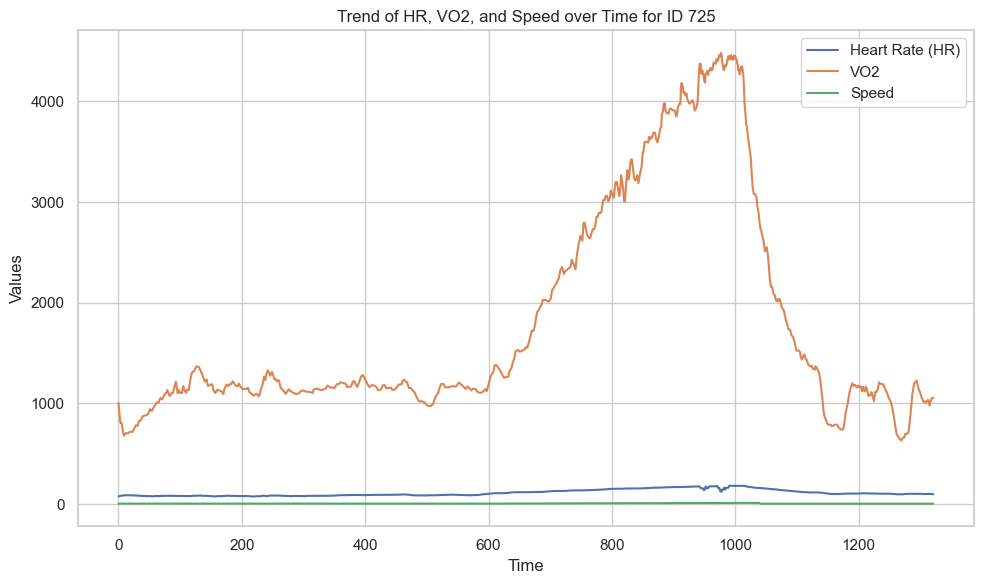

In [674]:
# Filter test_measure data for ID 725

id_725_data = test_measure[test_measure["ID"] == 725]

# Plot three variables: HR (Heart Rate), VO2, and Speed against time in single canva
plt.figure(figsize=(10, 6))
plt.plot(id_725_data["time"], id_725_data["HR"], label="Heart Rate (HR)")
plt.plot(id_725_data["time"], id_725_data["VO2"], label="VO2")
plt.plot(id_725_data["time"], id_725_data["Speed"], label="Speed")

plt.title("Trend of HR, VO2, and Speed over Time for ID 725")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 59 Create a scatter plot with a regression line using Altair, take a random sample data with features 'x' and 'y'.


In [677]:
# Generate random sample data
np.random.seed(42)
data = pd.DataFrame({
    'x': np.random.rand(100) * 10,
    'y': 2.5 * np.random.rand(100) * 10 + 5  # Roughly linear with some noise
})

# Convert to altair data source
chart = alt.Chart(data).mark_point().encode(
    x='x',
    y='y'
).properties(
    title='Scatter Plot with Regression Line'
)

# Add regression line
regression = chart.transform_regression('x', 'y').mark_line(color='red')

# Combine chart and regression line
final_chart = chart + regression
final_chart.display()

alt.LayerChart(...)

### 60 Use a strip plot to illustrate the distribution of Heart Rate Reserve (HRR) values, highlighting the lowest and highest values to showcase the range of HRR.


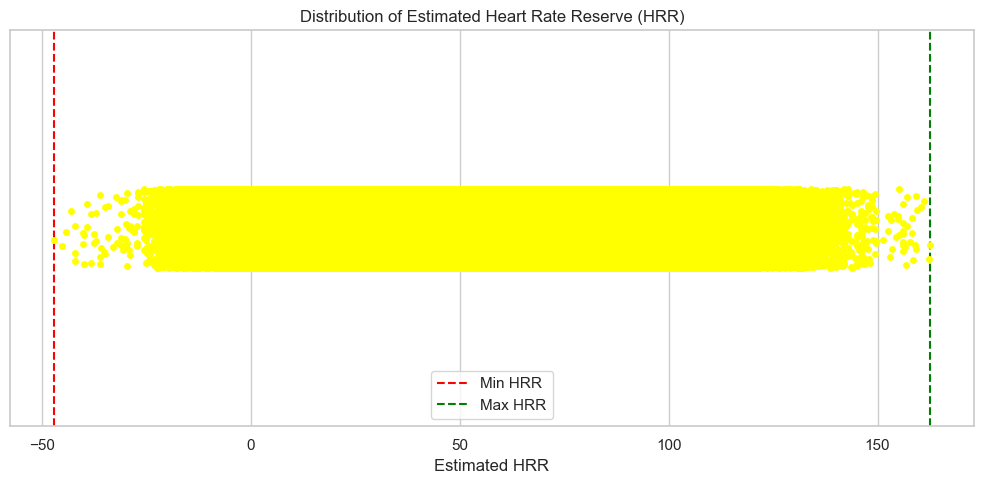

In [680]:
merged_df = pd.merge(subject_info, test_measure, on='ID', how='inner')
merged_df['Estimated_HRR'] = (220 - merged_df['Age']) - merged_df['HR']

plt.figure(figsize=(10, 5))
sns.stripplot(data=merged_df, x='Estimated_HRR', color='yellow', jitter=True)

plt.axvline(merged_df['Estimated_HRR'].min(), color='red', linestyle='--', label='Min HRR')
plt.axvline(merged_df['Estimated_HRR'].max(), color='green', linestyle='--', label='Max HRR')

plt.title("Distribution of Estimated Heart Rate Reserve (HRR)")
plt.xlabel("Estimated HRR")
plt.legend()
plt.tight_layout()
plt.show()


### 61 Create a swarm plot to visualize the relationship between humidity and temperature for each gender.


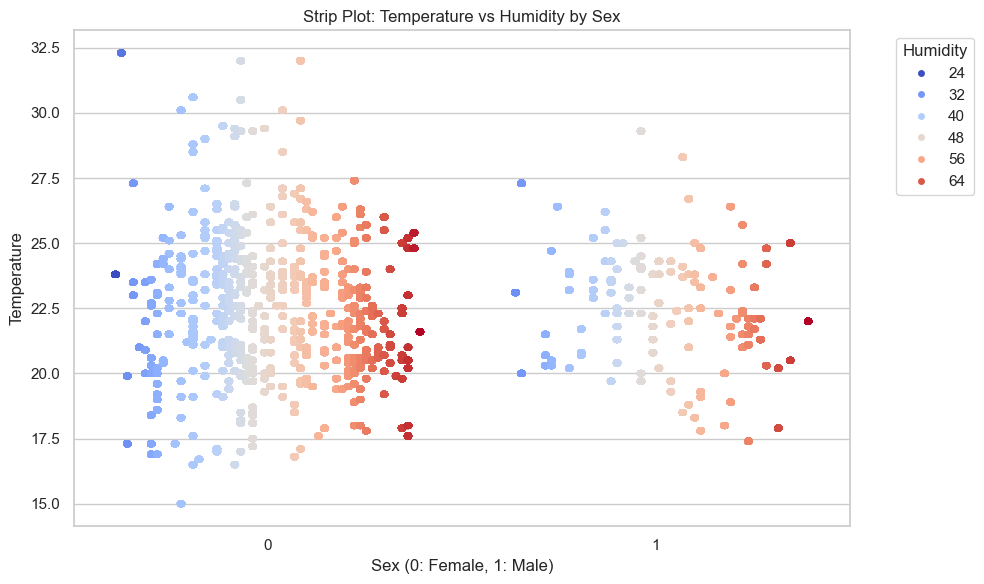

In [682]:
merged_df = pd.merge(subject_info, test_measure, on='ID', how='inner')
plt.figure(figsize=(10, 6))
sns.stripplot(data=merged_df, x='Sex', y='Temperature', hue='Humidity', palette='coolwarm', dodge=True)
plt.title('Strip Plot: Temperature vs Humidity by Sex')
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Temperature')
plt.legend(title='Humidity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 62 Analyze the relationship between fitness levels and physiological attributes and identify trends in the scatter plot of VO2 max (ml/kg/min) versus age


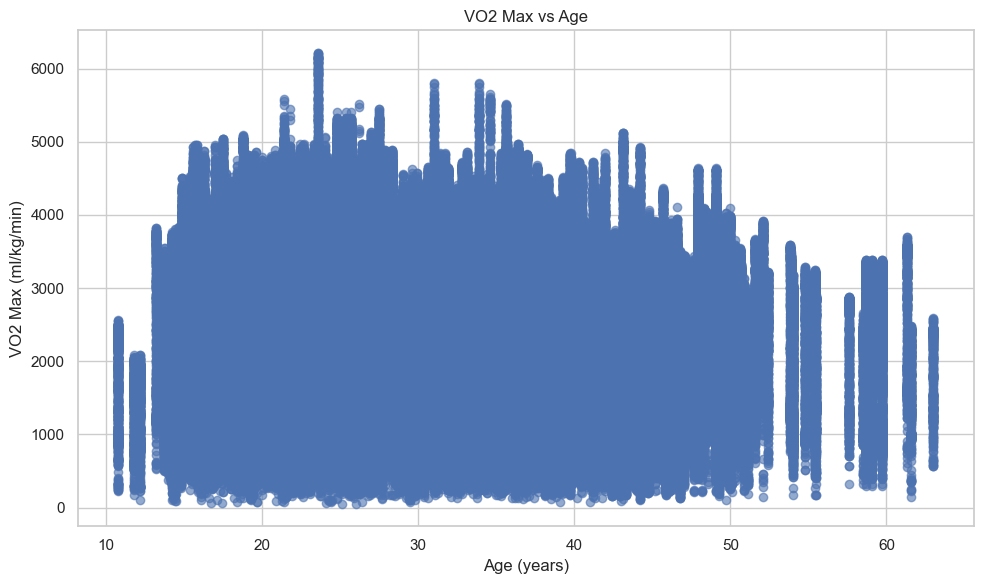

In [684]:

# Merge datasets using 'ID' column
merged_df = pd.merge(subject_info, test_measure, on='ID')

# Create scatter plot: VO2 vs Age
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Age'], merged_df['VO2'], alpha=0.6)
plt.title('VO2 Max vs Age')
plt.xlabel('Age (years)')
plt.ylabel('VO2 Max (ml/kg/min)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 63 Calculate the warm-up time, GET time, cool-down time, for each athlete test and find athlete who has maximum GET time ?


In [686]:
# Initialize list for results
results = []

# group  by  test ID
for test_id, group in test_measure.groupby('ID_test'):
    group = group.sort_values('time')

    # To Find warm-up end (first time VO2 > 500)
    warmup_end = group[group['VO2'] > 500]['time'].min()
    if pd.isna(warmup_end):
        warmup_end = group['time'].min()

    # To Find GET end (first time RR > 30 after warm-up)
    get_end = group[(group['time'] > warmup_end) & (group['RR'] > 30)]['time'].min()
    if pd.isna(get_end):
        get_end = group['time'].max()

    # calclulate Compute durations
    warmup_time = warmup_end - group['time'].min()
    get_time = get_end - warmup_end
    cooldown_time = group['time'].max() - get_end

    results.append({
        'ID_test': test_id,
        'Warmup_Time': warmup_time,
        'GET_Time': get_time,
        'Cooldown_Time': cooldown_time
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# To Find the athlete with max GET time
max_get = results_df[results_df['GET_Time'] == results_df['GET_Time'].max()]

print (max_get)

    ID_test  Warmup_Time  GET_Time  Cooldown_Time
838   747_1            0      1156            467


### 64 Compare the time it takes to multiply each element in a large array by 2  using an explicit loop and a vectorized operation with NumPy


In [688]:
import time

arr_size = 10000000
arr = np.arange(arr_size)

# using explicit loop method
start_time = time.time()
for i in range(arr_size):
    arr[i] = arr[i] * 2
end_time = time.time()
explicit_loop_time = end_time - start_time

# NumPy vectorized operation method
arr = np.arange(arr_size) # Reset array
start_time = time.time()
arr = arr * 2
end_time = time.time()
numpy_time = end_time - start_time

print(f"Time taken by explicit loop method: {explicit_loop_time:.4f} seconds")
print(f"Time taken by NumPy vectorized operation method: {numpy_time:.4f} seconds")
print(f"NumPy was {explicit_loop_time/numpy_time:.0f} times faster")


Time taken by explicit loop method: 4.5677 seconds
Time taken by NumPy vectorized operation method: 0.0180 seconds
NumPy was 254 times faster


In [712]:
### Make copies of the dataframes subject_i and test_m to work on the questions. 
### This will help avoid challenges while merging the notebooks.
#Make a dupicate dataframes to work on the questions and remove rows with Nan Values
subject_i = pd.read_csv("subject-info.csv")
test_m = pd.read_csv("test_measure.csv")

subject_df = subject_i.copy()
test_df= test_m.copy()

In [714]:
subject_df['Sex'].replace(0,'Male',inplace=True)
subject_df['Sex'].replace(1,'Female',inplace=True)

In [716]:
subject_df.head(10)

Age  Weight  Height  Humidity  Temperature     Sex   ID ID_test
0  10.8    48.8   163.0      39.0         20.7  Female  543   543_1
1  11.8    41.0   150.0      41.0         22.3  Female   11    11_1
2  12.2    46.0   160.0      37.0         21.5    Male  829   829_1
3  13.2    71.0   190.0      49.0         23.8  Female  284   284_1
4  13.7    53.8   169.7      40.0         25.3    Male  341   341_1
5  13.8    53.4   171.0      42.0         24.4    Male  341   341_2
6  14.0    46.0   160.0      40.0         25.3    Male  343   343_1
7  14.1    50.0   168.9      42.0         24.2    Male  330   330_1
8  14.1    47.2   160.2      40.0         25.2    Male  338   338_1
9  14.1    49.7   160.1      40.0         25.8    Male  339   339_1

### 65. Calculate the percentage of male athletes who exceeded, the maximum treadmill speed of female athletes.

In [719]:
# taking max speed of the ID
max_speed  = test_df.groupby('ID')['Speed'].max().reset_index()
max_speed.columns = ['ID', 'MaxSpeed']
max_speed['Sex'] = subject_df['Sex']
max_speed

ID  MaxSpeed     Sex
0      1      18.1  Female
1      2      16.3  Female
2      3      18.1    Male
3      4      16.2  Female
4      5      14.4    Male
..   ...       ...     ...
852  853      14.1    Male
853  854      11.4    Male
854  855      18.1    Male
855  856      17.0    Male
856  857      15.0    Male

[857 rows x 3 columns]

In [721]:
# Extracting the speed values of the female athletes as a list
female_speed = max_speed[max_speed['Sex'] =='Female']['MaxSpeed'].tolist()
#print(len(female_max_speed))   138
print(min(female_speed))  
print(max(female_speed)) 

7.0
21.8


In [723]:
#Extracting the speed values of the male athletes as a list
male_speed = max_speed[max_speed['Sex'] =='Male']['MaxSpeed'].tolist()
#print(len(male_speed)) 719
print(min(male_speed)) 
print(max(male_speed)) 

8.5
23.1


In [725]:
#extracting the number of males whose speed is more than 12.94 which is the maximun speed of female athletes
males_greater_than_female_maxspeed = [num for num in male_speed if num > max(female_speed)]
print(len(males_greater_than_female_maxspeed)) # 98 males have  speed more than max. average speed of females


4


In [727]:
# Final Solution to #65
# To calculate the percentage of male athletes who exceeded, the maximum treadmill speed of female athletes. 
# method 1: if we want only the %of males out of total males
perc1 = (len(males_greater_than_female_maxspeed)/ len(male_speed))* 100

#method2: if we want the %of males out of total males + total females
perc2 = (len(males_greater_than_female_maxspeed)/ (len(male_speed) + len(female_speed)))* 100

print("The % of males out of only the total males who exceeded the maximum treadmill speed of female athletes is", round(perc1,2))
print("The % of males out of total population who exceeded the maximum treadmill speed of female athletes is",round(perc2,2))


The % of males out of only the total males who exceeded the maximum treadmill speed of female athletes is 0.56
The % of males out of total population who exceeded the maximum treadmill speed of female athletes is 0.47


### 66. Visualize the number of test taken by participants and their trend of maximum Vo2 level as dual chart ?


In [730]:
#number of test taken by participants
testcount = test_df.groupby('ID')['ID_test'].nunique().reset_index()
testcount.columns = ['ID', 'testCounts']

In [732]:
# maximum Vo2 level
vo2max = test_df.groupby('ID')['VO2'].max().reset_index()
vo2max.columns = ['ID', 'Vo2Max']

In [734]:
participants_max_vo2 = pd.merge(testcount, vo2max, on='ID')
participants_max_vo2.head()

ID  testCounts  Vo2Max
0   1           1  3267.0
1   2           1  2833.0
2   3           1  3692.0
3   4           1  4110.0
4   5           1  4053.0

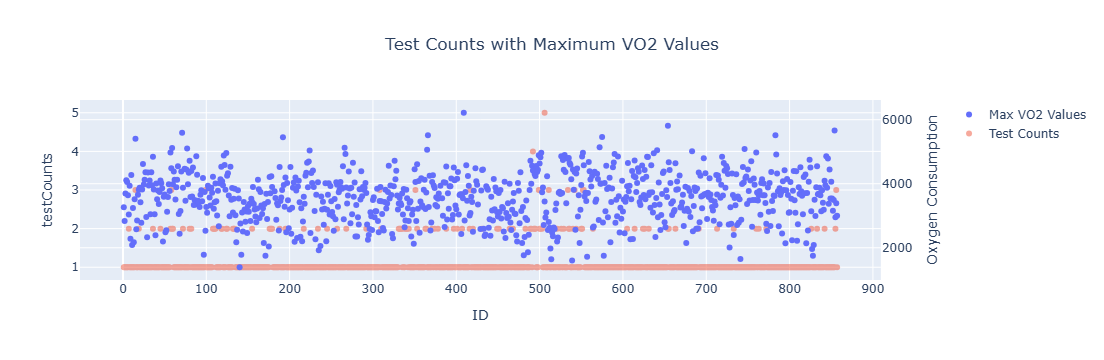

In [736]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs= [[{"secondary_y" :True}]])

fig.add_trace(
            go.Scatter(x = participants_max_vo2["ID"], y = participants_max_vo2['Vo2Max'], name = "Max VO2 Values", mode='markers'),
            secondary_y =True
)

fig.add_trace(
            go.Scatter(x = participants_max_vo2["ID"], y = participants_max_vo2['testCounts'], name = "Test Counts", mode='markers',opacity=0.5),
            secondary_y =False
)


fig.update_layout(title_text = "Test Counts with Maximum VO2 Values", title_x =0.5)
fig.update_xaxes(title_text = "ID")
fig.update_yaxes(title_text = "testCounts", secondary_y =False)
fig.update_yaxes(title_text = "Oxygen Consumption", secondary_y =True)


fig.show()

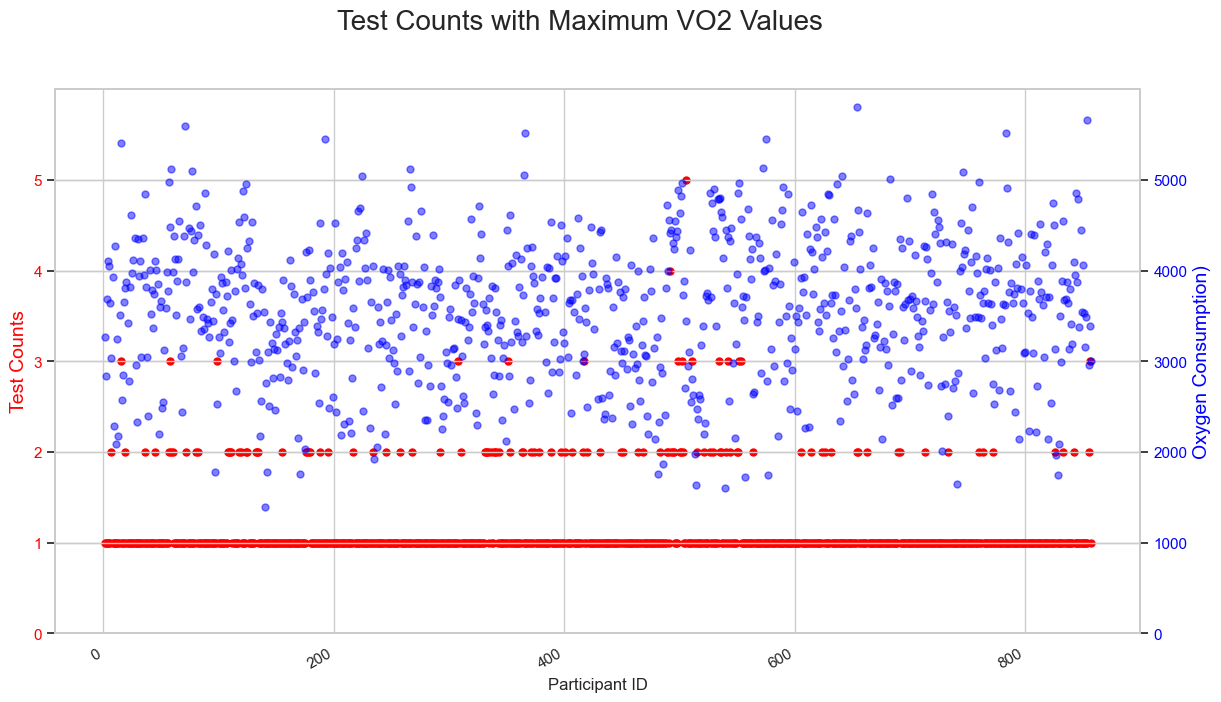

In [737]:
# Using Matplotlib

COLOR_1 = "red"
COLOR_2 = "blue"

fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

ax1.scatter(x = participants_max_vo2["ID"], y = participants_max_vo2['testCounts'],  color=COLOR_1, s= 25)
ax2.scatter(x = participants_max_vo2["ID"], y = participants_max_vo2['Vo2Max'], color=COLOR_2, alpha= 0.5, s=25)


ax1.set_xlabel("Participant ID")
ax1.set_ylabel("Test Counts", color=COLOR_1, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_1)
ax1.set_ylim([0, 6]) # Set y limit for second y axis
ax1.set_yticks(np.arange(0, 6, 1)) # Set increments for second y axis


ax2.set_ylabel("Oxygen Consumption)", color=COLOR_2, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_2)
ax2.set_ylim([0, 6000]) # Set y limit for second y axis
ax2.set_yticks(np.arange(0, 6000, 1000)) # Set increments for second y axis

fig.suptitle("Test Counts with Maximum VO2 Values", fontsize=20)
fig.autofmt_xdate()

plt.show()

### 67. Create violin chart for any two column from the dataset ?

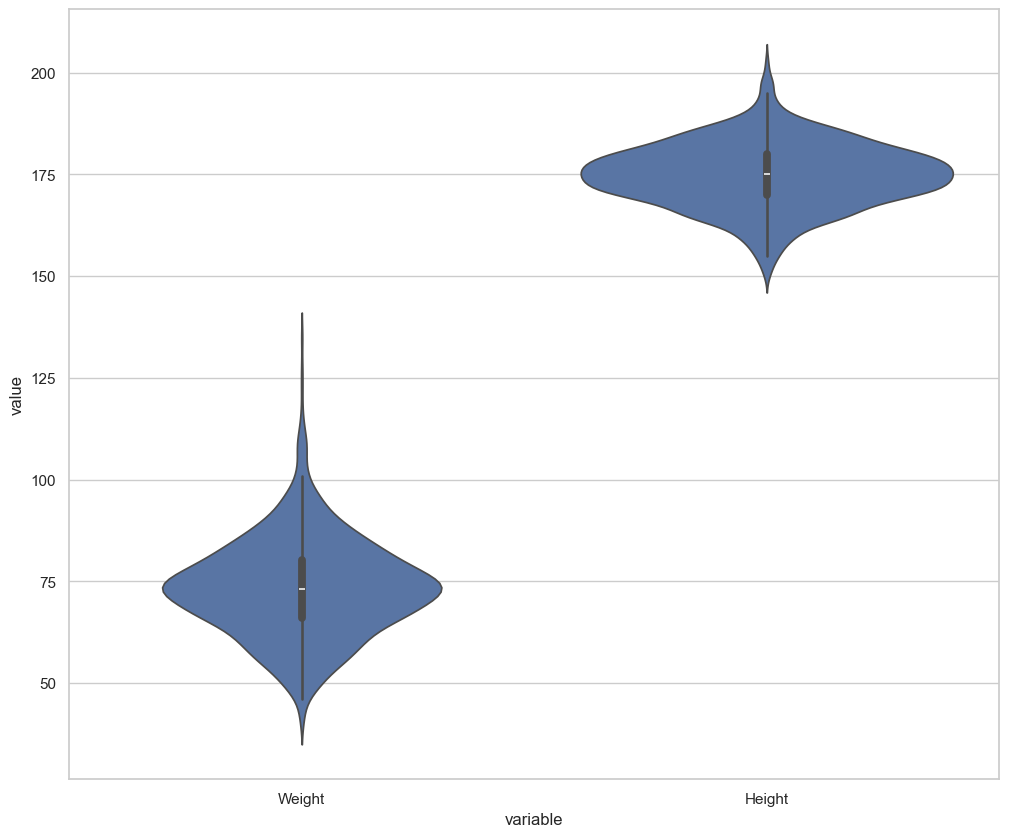

In [741]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)

df = subject_df[['Weight','Height']]

# Melt the dataframe to long format
df_melted = pd.melt(df, var_name='variable', value_name='value')

# Create the violin plot
fig =plt.figure(figsize =(12,10))

sns.violinplot(x='variable', y='value', data=df_melted)

# Show the plot
plt.show()

### 68. Calculate BSA (Body surface area) without using function and store as column in dataframe and categorize.


In [744]:

# Using the most commonly used formula "Du Bois Formula:BSA (m²) = 0.007184 x (Height (cm) ^ 0.725) x (Weight (kg) ^ 0.425)."
#subject_df['BSA'] = round((0.007184 * (subject_df['Height']**0.725) * (subject_df['Weight']**0.425)),2)

subject_df['BSA'] = round(np.sqrt(subject_df['Height']*subject_df['Weight']/3600), 2)

# Categorize BSA
def categorize_bsa(bsa):
    if bsa < 1.6:
        return 'Low'
    elif 1.6 <= bsa < 2.0:
        return 'Average'
    else:
        return 'High'

subject_df['bsa_category'] = subject_df['BSA'].apply(categorize_bsa)

subject_df.head(15)


Age  Weight  Height  Humidity  Temperature     Sex   ID ID_test   BSA  \
0   10.8    48.8   163.0      39.0         20.7  Female  543   543_1  1.49   
1   11.8    41.0   150.0      41.0         22.3  Female   11    11_1  1.31   
2   12.2    46.0   160.0      37.0         21.5    Male  829   829_1  1.43   
3   13.2    71.0   190.0      49.0         23.8  Female  284   284_1  1.94   
4   13.7    53.8   169.7      40.0         25.3    Male  341   341_1  1.59   
5   13.8    53.4   171.0      42.0         24.4    Male  341   341_2  1.59   
6   14.0    46.0   160.0      40.0         25.3    Male  343   343_1  1.43   
7   14.1    50.0   168.9      42.0         24.2    Male  330   330_1  1.53   
8   14.1    47.2   160.2      40.0         25.2    Male  338   338_1  1.45   
9   14.1    49.7   160.1      40.0         25.8    Male  339   339_1  1.49   
10  14.1    46.6   161.5      41.0         26.5    Male  343   343_5  1.45   
11  14.2    65.2   170.1      42.0         24.4    Male  333   333_1  1.76   
12  14.2    64.6   175.0      42.0         24.4    Male  335   335_1  1.77   
13  14.2    51.0   163.0      42.0         24.4    Male  339   339_5  1.52   
14  14.2    57.8   164.2      40.0         25.8    Male  344   344_1  1.62   

   bsa_category  
0           Low  
1           Low  
2           Low  
3       Average  
4           Low  
5           Low  
6           Low  
7           Low  
8           Low  
9           Low  
10          Low  
11      Average  
12      Average  
13          Low  
14      Average

### 69. Write a python function that efficiently processes large data into chunks to analyze average heart rate and maximum oxygen consumption for each test. Print the chunks during processing.


In [747]:

# Due to large volume of the test dataset, I have only sampled 100 rows of data and chunk size of 50 for this question

def test_process(sampled_df, chunk_size = 50):
    
    for i in range(0, len(sampled_df), chunk_size):
        chunk = sampled_df[i:i + chunk_size]
        print("---------------------------------------------------------------")
        print(f"Processing chunk {i // chunk_size + 1} of {chunk_size} rows")
        print("---------------------------------------------------------------")
        print(chunk.head())
    
        test_ids = chunk['ID_test'].unique()
    
        # Add processing logic here to analyze average heart rate and maximum oxygen consumption for each test
        for test_id in test_ids:
            test_data = chunk[chunk['ID_test'] == test_id]
            # calculate average heart rate and maximum oxygen consumption 
            avg_heart_rate = test_data['HR'].mean(skipna=True)
            max_oxygen_consumption = test_data['VO2'].max()
            print("\n")
            print(f"Test ID: {test_id}")
            print(f"average heart rate: {avg_heart_rate:.2f}")
            print(f"maximum oxygen consumption: {max_oxygen_consumption:.2f}")
    print("-----------------------------------------------------------------")
    
       
sampled_df = test_df.sample(n= 100, random_state =123)
test_process(sampled_df, chunk_size=50)



---------------------------------------------------------------
Processing chunk 1 of 50 rows
---------------------------------------------------------------
        time  Speed     HR     VO2    VCO2    RR     VE ID_test   ID
242270   260    6.1  103.0  1073.0   838.0  18.0   21.4   363_1  363
68174    558   11.5  157.0  1936.0  1798.0  48.0   69.1   99_47   99
63090    876   16.8  202.0  3159.0  3668.0  52.0  114.5    90_1   90
346141  1021    5.0  122.0  1347.0  1901.0  31.0   63.7   508_1  508
208225   244    6.2  103.0  1048.0   962.0  18.0   21.8   321_1  321


Test ID: 363_1
average heart rate: 103.00
maximum oxygen consumption: 1073.00


Test ID: 99_47
average heart rate: 157.00
maximum oxygen consumption: 1936.00


Test ID: 90_1
average heart rate: 202.00
maximum oxygen consumption: 3159.00


Test ID: 508_1
average heart rate: 122.00
maximum oxygen consumption: 1347.00


Test ID: 321_1
average heart rate: 103.00
maximum oxygen consumption: 1048.00


Test ID: 518_1
average hear

# This is for the whole test measure data
'''
def treadmill_data(filename, chunk_size= 2000):
    
    print(f"Processing Data in Chunks of {chunk_size} rows...")
    print("---------------------------------------------------")
    for chunk in pd.read_csv(filename, chunksize = chunk_size):
        print("Processing data chunks:")
        print(chunk.head())
        test_ids = chunk['ID_test'].unique()

        for test_id in test_ids:
            test_data = chunk[chunk['ID_test'] == test_id]
            # calculate average heart rate and maximum oxygen consumption 
            avg_heart_rate = test_data['HR'].mean(skipna=True)
            max_oxygen_consumption = test_data['VO2'].max()
            print("\n")
            print(f"Test ID: {test_id}")
            print(f"average heart rate: {avg_heart_rate:.2f}")
            print(f"maximum oxygen consumption: {max_oxygen_consumption:.2f}")
        
    print("-----------------------------------------------------------------")


treadmill_data('test_measure.csv', chunk_size=2000)

'''

### 70. How does the body's production of carbon dioxide related to the consumption of oxygen with increasing levels of pulmonary ventilation during GET? 


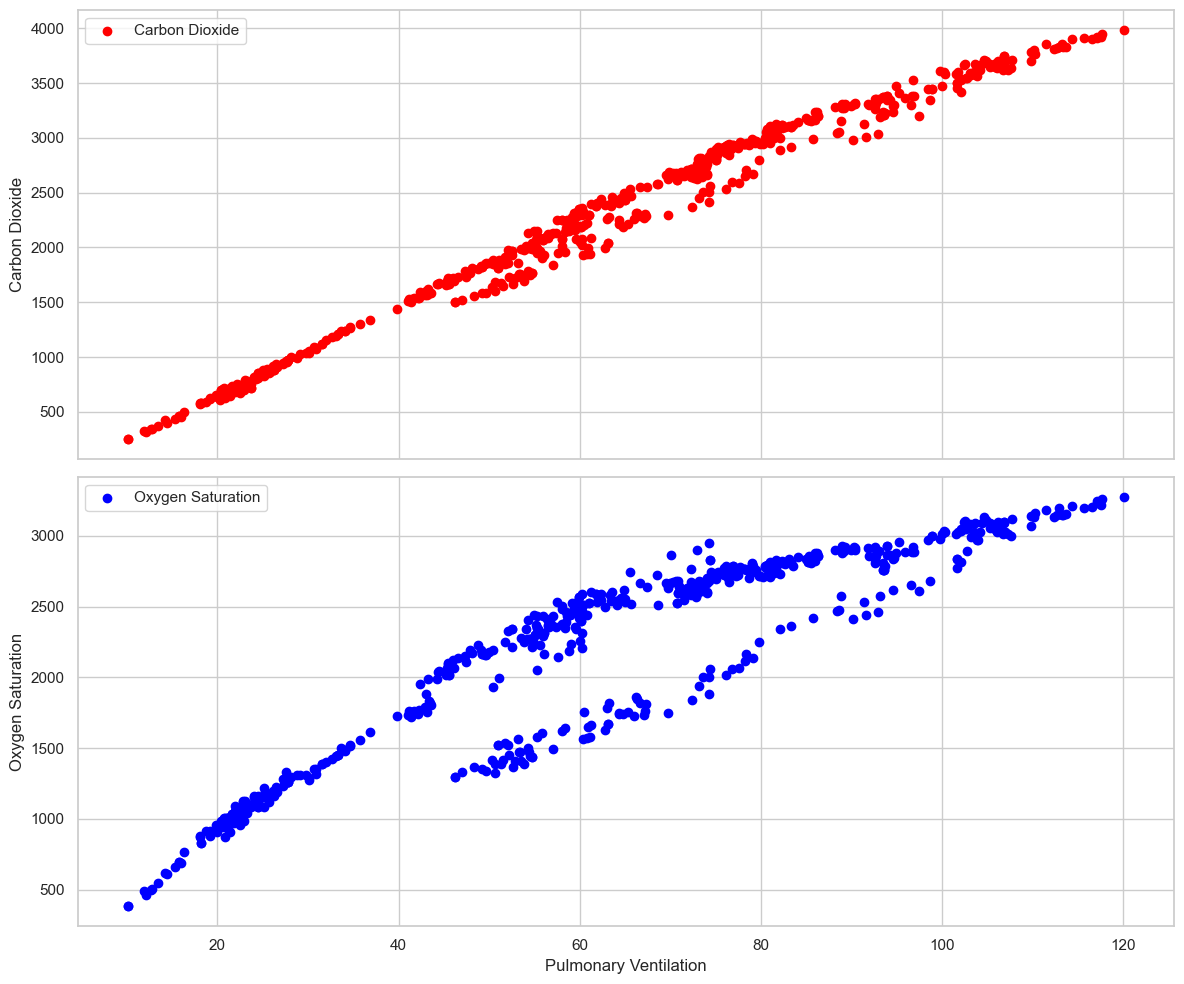

In [751]:

# VE on x axis, vo2 and vco2 on y axis

#Consider Athelete with ID 100 
athlete_100 = test_df[test_df['ID_test']== '100_1'].reset_index()
df= athlete_100
df.head()

df.drop('index', axis=1, inplace=True)
df.head()

# Method 1: Using matplotlib subplotsdf= athlete_100
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True) # 2 rows, 1 column

axes[0].scatter(np.array(df['VE']), np.array(df['VCO2']), label='Carbon Dioxide', color='red')
axes[0].set_ylabel('Carbon Dioxide')
axes[0].legend()

axes[1].scatter(np.array(df['VE']), np.array(df['VO2']), label='Oxygen Saturation', color='blue')
axes[1].set_ylabel('Oxygen Saturation')
axes[1].set_xlabel('Pulmonary Ventilation')
axes[1].legend()

plt.tight_layout()
plt.show()


### Analysis: 

It is observed from the plots, as the pulmonary ventilation increases, oxygen consumption tends to increase and subsequently production of carbon dioxide increases. During a graded exercise test, as the pulmonary ventilation increases with exercise intensity, the body's carbon dioxide (CO2) production and oxygen consumption (O2) rates also rise proportionally. This is true during accleration but with decceleration of treadmill the rate of relationship between oxygen consumption and carbon dioxide production slightly differed or deviated.







### 71. Create a Funnel chart of Age Category (Child, Teen, Adult and Senior) ?


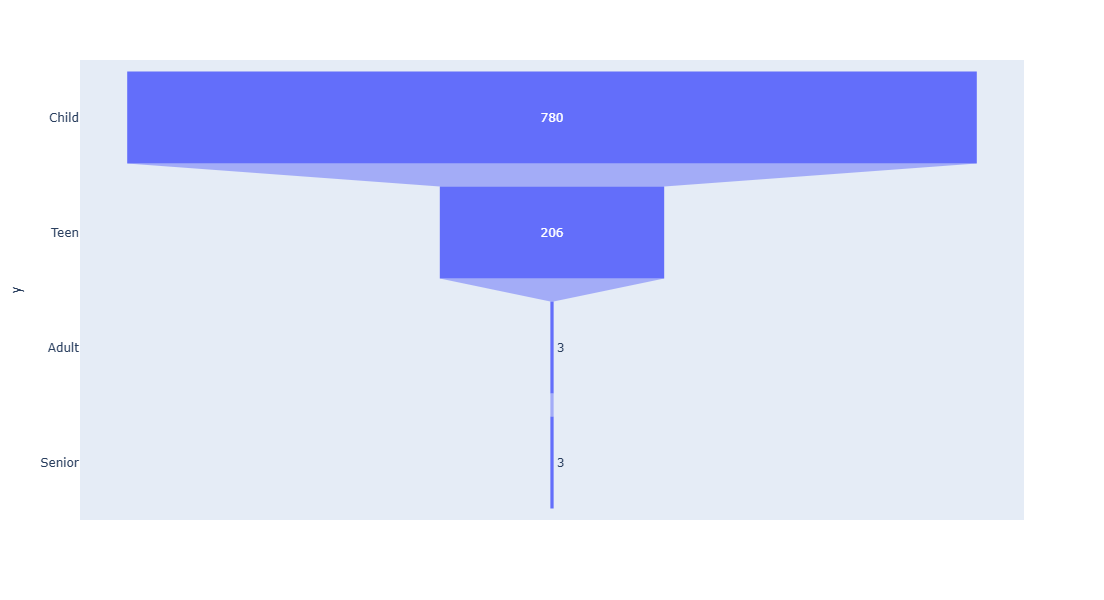

In [755]:
#Age Category
def age_category(df):
    if df['Age'] > 10 and df['Age'] < 13: 
        return 'Child'
    if df['Age'] >= 13 and df['Age'] < 20: 
        return 'Teen'
    if df['Age'] >= 20 and df['Age'] < 60: 
        return 'Adult'
    if df['Age'] >= 60 : 
        return 'Senior'

subject_df['Age Category'] = subject_df.apply(lambda x : age_category(x), axis = 1)
subject_df.head()



subject_df['Age Category'].unique()
age_df = subject_df['Age Category'].value_counts()
age_df.values

fig = px.funnel(subject_df, x = age_df.values, y =subject_df['Age Category'].unique(), width = 800, height = 600)
fig.show()

### 72. Visualize different physiological parameters over time for a specific test of an athlete using multiple panels?


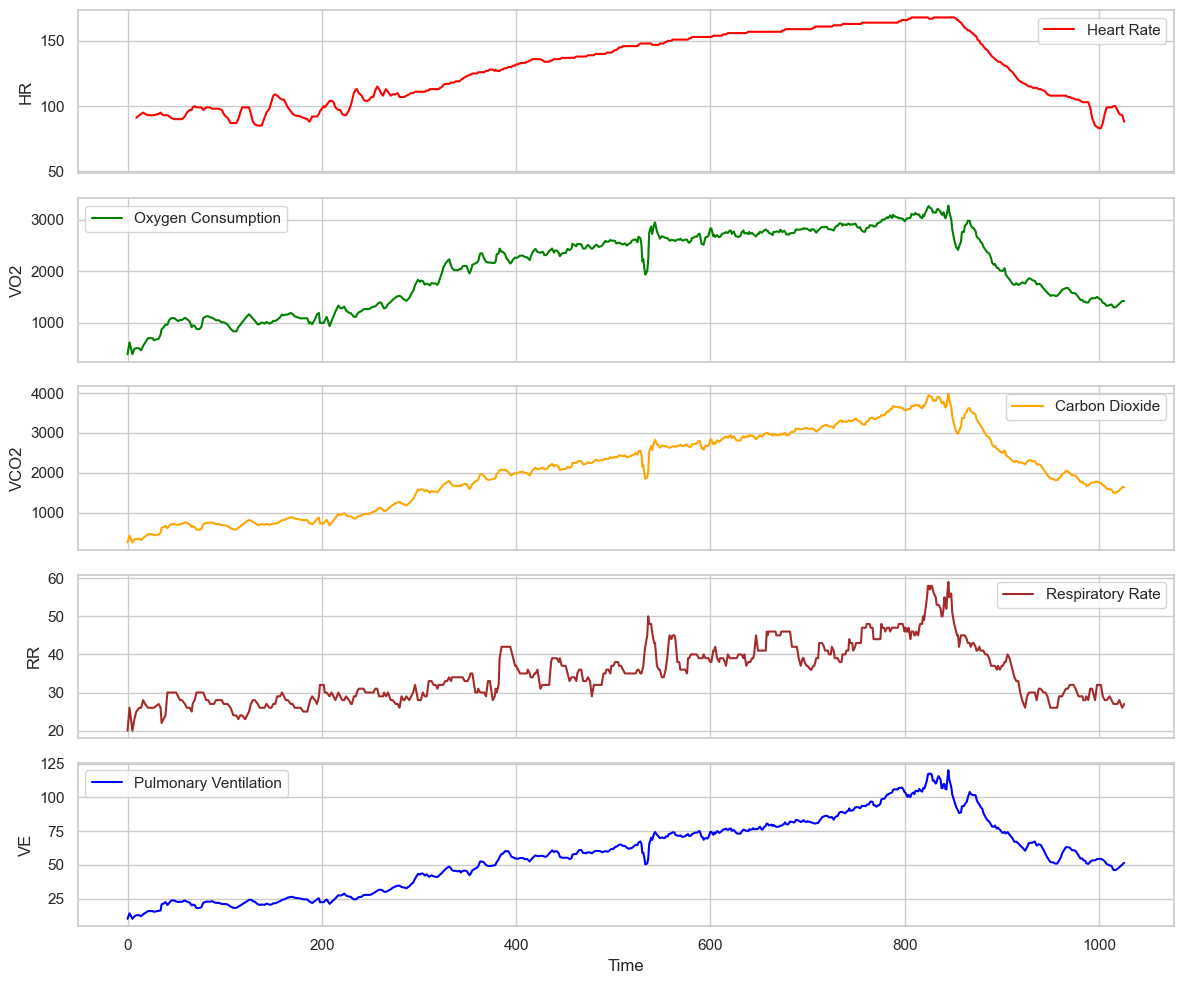

In [758]:
#Consider Athelete with ID 100 
df_100 = test_df[test_df['ID_test']== '100_1'].reset_index()
df_100.head()

# Drop the indexes
df_100.drop('index', axis=1, inplace=True)
df_100.head()

#  Using matplotlib subplots

fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True) # 5 rows, 1 column

axes[0].plot(np.array(df_100['time']), np.array(df_100['HR']), label='Heart Rate', color='red')
axes[0].set_ylabel('HR')
axes[0].legend()

axes[1].plot(np.array(df_100['time']), np.array(df_100['VO2']), label='Oxygen Consumption', color='green')
axes[1].set_ylabel('VO2')
axes[1].legend()

axes[2].plot(np.array(df_100['time']), np.array(df_100['VCO2']), label='Carbon Dioxide', color='orange')
axes[2].set_ylabel('VCO2')
axes[2].legend()

axes[3].plot(np.array(df_100['time']), np.array(df_100['RR']), label='Respiratory Rate', color='brown')
axes[3].set_ylabel('RR')
axes[3].legend()

axes[4].plot(np.array(df_100['time']), np.array(df_100['VE']), label='Pulmonary Ventilation', color='blue')
axes[4].set_ylabel('VE')
axes[4].set_xlabel('Time')
axes[4].legend()


plt.tight_layout()
plt.show()

### 73. Print first 10 records of the subject_info based on ID, without using head() method.

In [761]:
# using iloc we can access the first 10 rows/ records of a dataframe
subject_df.iloc[: 11]    

Age  Weight  Height  Humidity  Temperature     Sex   ID ID_test   BSA  \
0   10.8    48.8   163.0      39.0         20.7  Female  543   543_1  1.49   
1   11.8    41.0   150.0      41.0         22.3  Female   11    11_1  1.31   
2   12.2    46.0   160.0      37.0         21.5    Male  829   829_1  1.43   
3   13.2    71.0   190.0      49.0         23.8  Female  284   284_1  1.94   
4   13.7    53.8   169.7      40.0         25.3    Male  341   341_1  1.59   
5   13.8    53.4   171.0      42.0         24.4    Male  341   341_2  1.59   
6   14.0    46.0   160.0      40.0         25.3    Male  343   343_1  1.43   
7   14.1    50.0   168.9      42.0         24.2    Male  330   330_1  1.53   
8   14.1    47.2   160.2      40.0         25.2    Male  338   338_1  1.45   
9   14.1    49.7   160.1      40.0         25.8    Male  339   339_1  1.49   
10  14.1    46.6   161.5      41.0         26.5    Male  343   343_5  1.45   

   bsa_category Age Category  
0           Low        Child  
1           Low        Child  
2           Low        Child  
3       Average         Teen  
4           Low         Teen  
5           Low         Teen  
6           Low         Teen  
7           Low         Teen  
8           Low         Teen  
9           Low         Teen  
10          Low         Teen

### 74. Determine the treadmill speed range and age range in which you observe the highest average heart rate.


In [764]:
# Defining Age range
def age_range(df):
    if df['Age'] >= 10 and df['Age'] <= 20: 
        return '10-20'
    if df['Age'] > 20  and df['Age'] <= 30: 
        return '20-30'
    if df['Age'] > 30 and df['Age'] <= 40: 
        return '30-40'
    if df['Age'] > 40 and df['Age'] <= 50: 
        return '40-50'
    if df['Age'] > 50 and df['Age'] <= 60: 
        return '50-60'
    if df['Age'] > 60 : 
        return '60+'

subject_df['AgeRange'] = subject_df.apply(lambda x : age_range(x), axis = 1)
#subject_df


In [766]:
# Defining speed range
def speed_range(df):
    if df['Speed'] >=0 and df['Speed'] <=5: 
        return '0-5'
    if df['Speed'] > 5 and df['Speed'] <= 10: 
        return '5-10'
    if df['Speed'] > 10 and df['Speed'] <= 15: 
        return '10-15'
    if df['Speed'] >15 and  df['Speed'] <= 20: 
        return '15-20'
    if df['Speed'] > 20:
        return '20-30'

test_df['SpeedRange'] = test_df.apply(lambda x : speed_range(x), axis = 1)
#test_df

In [767]:
# Merge subject and test data
test_cleaned = test_df.dropna(subset=['HR'])
merge_df = test_cleaned.merge(subject_df, on=['ID','ID_test'])
merge_df.head()

time  Speed    HR    VO2   VCO2    RR    VE ID_test  ID SpeedRange   Age  \
0     0    5.0  63.0  478.0  360.0  27.0  13.3     2_1   2        0-5  33.8   
1     2    5.0  75.0  401.0  295.0  23.0  10.3     2_1   2        0-5  33.8   
2     4    5.0  82.0  449.0  319.0  29.0  12.2     2_1   2        0-5  33.8   
3     7    5.0  87.0  461.0  340.0  28.0  12.8     2_1   2        0-5  33.8   
4     9    5.0  92.0  574.0  417.0  28.0  14.6     2_1   2        0-5  33.8   

   Weight  Height  Humidity  Temperature   Sex  BSA bsa_category Age Category  \
0    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
1    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
2    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
3    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
4    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   

  AgeRange  
0    30-40  
1    30-40  
2    30-40  
3    30-40  
4    30-40

In [770]:
# Grouping by treadmill speed range and age range
grouped = merge_df.groupby(['SpeedRange', 'AgeRange'])['HR'].mean().reset_index()

# Find the group with highest avg HR
max_hr_group = grouped.iloc[grouped['HR'].idxmax()]
print("Highest Average Heart Rate Group:\n")
print(max_hr_group)

Highest Average Heart Rate Group:

SpeedRange         15-20
AgeRange           10-20
HR            186.536867
Name: 12, dtype: object


### 75. Identify subjects whose heart rate (HR) is consistently above their age group’s 75th percentile.

In [773]:
# Merge subject and test data after removing the null values from heart rate column
test_cleaned = test_df.dropna(subset=['HR'])
df1 = test_cleaned.merge(subject_df, on=['ID','ID_test'])

# Compute 75th percentile HR for each age group
hr_75th = df1.groupby('AgeRange')['HR'].quantile(0.75).to_dict()
print("The 75th percentiles of Heart rate for each Age Range is: \n",hr_75th)

# Add threshold column to each row for comparison
df1['HR_75th'] = df1['AgeRange'].map(hr_75th)

# select only required columns
selected_data = df1[['ID','AgeRange', 'HR', 'HR_75th']]
#selected_data.head()
new_data = selected_data.drop_duplicates()
#new_data.head()

The 75th percentiles of Heart rate for each Age Range is: 
 {'10-20': 181.0, '20-30': 175.0, '30-40': 170.0, '40-50': 163.0, '50-60': 157.0, '60+': 158.0}


In [775]:
# apply the transform function to check which HR values are above their 75th quartile
cons_subjects = new_data.groupby(['ID', 'AgeRange'])['HR'].transform(lambda x: x > x.quantile(0.75)).reset_index()
#cons_subjects

# Select only the data that returned TRUE 
sel_data = cons_subjects[cons_subjects['HR'] == True]
#print(len(sel_data))

# Extract the index values that are ID in the new_data
list_ID = sel_data['index'].tolist()
#print(list_ID)

filtered_df = new_data[new_data['ID'].isin(list_ID)]

# after selecting only the IDs that have HR True, we get 541 rows
f1 = filtered_df[filtered_df['HR'] > filtered_df['HR_75th'] ]
#f1

# Further filtering down the dataset to extract only the unique ID with HR greater than their 75th quantile
list1 = f1['ID'].unique()
# print(len(list1)) # 33 subjects

final_dataset = f1.drop_duplicates(subset=['ID'])
final_dataset.sort_values(by='AgeRange')

ID AgeRange     HR  HR_75th
291974  441    10-20  182.0    181.0
230167  347    10-20  182.0    181.0
291529  440    10-20  182.0    181.0
291172  439    10-20  182.0    181.0
253084  379    10-20  182.0    181.0
348927  514    20-30  176.0    175.0
189965  290    20-30  176.0    175.0
190395  291    20-30  176.0    175.0
333086  499    20-30  176.0    175.0
195268  301    20-30  176.0    175.0
292751  442    20-30  176.0    175.0
243403  365    20-30  176.0    175.0
251770  378    20-30  176.0    175.0
182031  275    30-40  171.0    170.0
240094  360    30-40  171.0    170.0
207478  320    30-40  171.0    170.0
200361  310    30-40  171.0    170.0
265480  398    40-50  164.0    163.0
266638  400    40-50  164.0    163.0
241538  363    40-50  164.0    163.0
194845  300    40-50  164.0    163.0
342029  506    40-50  164.0    163.0
251210  377    50-60  158.0    157.0

### 76. List the participants ID and test _ID who started their warm up with speed less than 5km/h ?


In [778]:
# Filter rows where speed less than 5 km/h
speed5_df = test_df[test_df['Speed'] < 5]

filtered_df = speed5_df.drop(columns = ['time','HR','VO2','VCO2', 'RR', 'VE','SpeedRange'])

warmup_df = filtered_df.drop_duplicates(subset=['ID', 'ID_test'])

# List of unique ID participants with warm up speed less than 5km/h
warmup_df
#.head(10) 


Speed ID_test   ID
1207      0.0     4_1    4
7433      0.0     1_1    1
25655     0.0    38_1   38
25990     0.0    39_1   39
26030     0.0    40_1   40
...       ...     ...  ...
571591    0.0   855_6  855
572209    0.0   855_1  855
572828    4.9   856_3  856
573447    4.9   856_2  856
574067    4.9   856_1  856

[365 rows x 3 columns]

### 77. Calculate the mean VO2 max for male and female athletes in the Get Phase.



In [781]:
# Merge datasets
df2 = test_df.merge(subject_df, on=['ID', 'ID_test'])
df2.head()

time  Speed    HR    VO2   VCO2    RR    VE ID_test  ID SpeedRange   Age  \
0     0    5.0  63.0  478.0  360.0  27.0  13.3     2_1   2        0-5  33.8   
1     2    5.0  75.0  401.0  295.0  23.0  10.3     2_1   2        0-5  33.8   
2     4    5.0  82.0  449.0  319.0  29.0  12.2     2_1   2        0-5  33.8   
3     7    5.0  87.0  461.0  340.0  28.0  12.8     2_1   2        0-5  33.8   
4     9    5.0  92.0  574.0  417.0  28.0  14.6     2_1   2        0-5  33.8   

   Weight  Height  Humidity  Temperature   Sex  BSA bsa_category Age Category  \
0    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
1    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
2    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
3    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   
4    68.0   171.1       NaN          NaN  Male  1.8      Average        Adult   

  AgeRange  
0    30-40  
1    30-40  
2    30-40  
3    30-40  
4    30-40

In [783]:
VO2_max = df2.groupby(['ID_test','Sex'])['VO2'].max().reset_index()
VO2_max.columns = ['ID_test','Sex', 'Max_VO2']
VO2_max

ID_test     Sex  Max_VO2
0     100_1    Male   3272.0
1     101_1    Male   3093.0
2     102_1    Male   3935.0
3     103_1    Male   3861.0
4     104_1    Male   3568.0
..      ...     ...      ...
987    98_1    Male   3741.0
988    99_1  Female   2278.0
989   99_47  Female   2029.0
990   99_54  Female   2532.0
991     9_1  Female   2282.0

[992 rows x 3 columns]

In [785]:
# FINAL: The mean VO2 max for male and female athletes in the Get Phase.
mean_VO2_max_by_gender  = VO2_max.groupby('Sex')['Max_VO2'].mean()
mean_VO2_max_by_gender 

Sex
Female    2547.737931
Male      3736.218900
Name: Max_VO2, dtype: float64

### 78. If you consider cool down time as the recovery period after reaching peak speed, display the participant details who has taken the longest Cool Down time.



In [788]:
#minimum time at minimum speed---> warmup
#max time , max speed
#maximum time at minimim speed ---> cool dowm
#longest Cool Down time  = maxtime of max speed - end time of the test       

# Merge datasets
#df2 = test_df.merge(subject_df, on=['ID', 'ID_test'])
#df2.head()

# For each participant, find the time when peak speed occurs
longest_cooldown = []

for pid in df2['ID_test'].unique():
    sub_df = df2[df2['ID_test'] == pid].sort_values('time')
    
    max_speed = sub_df['Speed'].max()
    peak_time = sub_df[sub_df['Speed'] == max_speed]['time'].max()
    
    cooldown_time = sub_df['time'].max() - peak_time
    
    longest_cooldown.append({
        'ID_test': pid,
        'CoolDownTime': cooldown_time
    })

# Create DataFrame and find the longest
cooldown_df = pd.DataFrame(longest_cooldown)
top = cooldown_df.sort_values('CoolDownTime', ascending=False).head(1)

# Merge with subject info
result = top.merge(subject_df, on='ID_test')
result[['ID_test', 'CoolDownTime', 'Age', 'Sex', 'Weight', 'Height']]


ID_test  CoolDownTime   Age   Sex  Weight  Height
0   218_1           762  45.6  Male    76.0   176.0

### 79. Identify the athlete who recorded the highest treadmill speed during the tests.

In [790]:
maxspeed_row_id = test_df['Speed'].idxmax()
maxspeed_row = test_df.iloc[maxspeed_row_id]
#print(maxspeed_row)
print("The ID of the athlete who recorded the highest treadmill speed during the test is", maxspeed_row['ID'])

test_df.iloc[maxspeed_row_id]

The ID of the athlete who recorded the highest treadmill speed during the test is 431


time            1233
Speed           23.1
HR             147.0
VO2           3437.0
VCO2          4483.0
RR               NaN
VE             135.5
ID_test        431_1
ID               431
SpeedRange     20-30
Name: 287937, dtype: object

### 80. Show the oxygen consumption trend analysis among women athletes across different age groups 

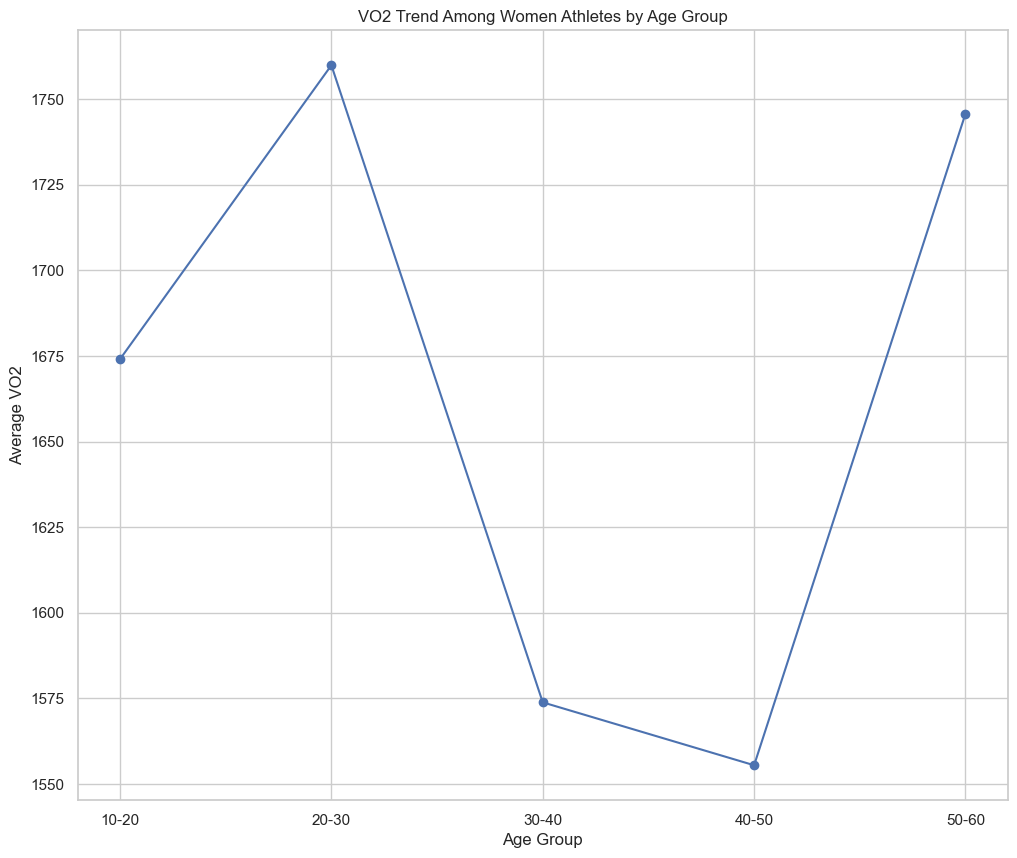

In [792]:
# take the merged dataset df2 and group by taking sex and agerange to compute the averahe oxygein consumption
df3 = df2.groupby(['Sex','AgeRange'])['VO2'].mean().reset_index()

# Filter the dataset df3 based on female athletes
women_df = df3[df3['Sex'] == 'Female']

# replace the VO2 name to avgO2
women_df.rename(columns={'VO2': 'avgO2'}, inplace=True)

women_df

# Plot the trend of VO2 among women athletes across different age groups using line plot

fig =plt.figure(figsize =(12,10))
plt.plot( np.array(women_df['AgeRange']) ,np.array(women_df['avgO2']), marker ='o', linestyle='-')
plt.title('VO2 Trend Among Women Athletes by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average VO2')
plt.grid(True)
plt.show()


###  Extra Question: Plot Violin Plot for Age category with respect to weight


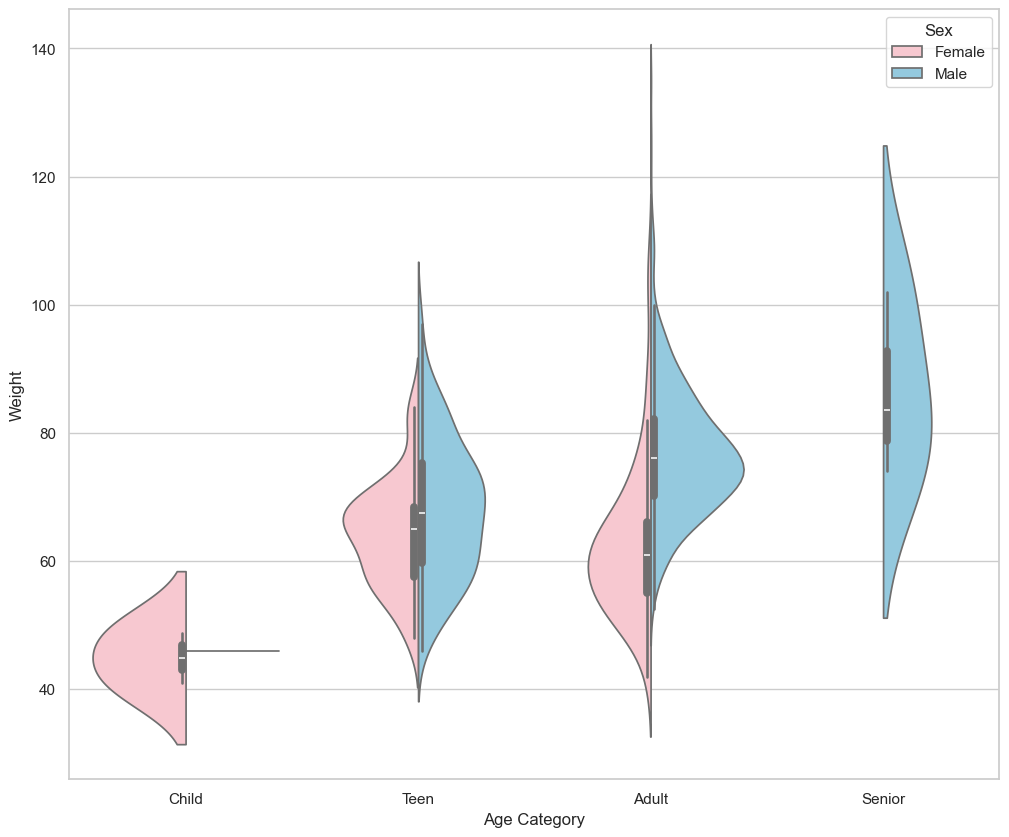

In [417]:
# Plot Violin Chart for Age category with respect to weight
fig =plt.figure(figsize =(12,10))
palette_dict = {'Male': 'Skyblue', 'Female': 'Pink'}
sns.violinplot(x='Age Category' ,y='Weight',data=subject_df, hue='Sex', palette=palette_dict ,split=True)
plt.show()
